# **Import Libraries**

In [1]:
from google.colab import drive
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import layers, models
from tqdm import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import glob
import warnings

In [2]:
warnings.filterwarnings('ignore')

# **Connecting to Google Drive**

In [3]:
# Mount Google Drive to access dataset
drive.mount('/content/drive')

Mounted at /content/drive


# **Set Constants and Dataset Path**

In [4]:
# ======================== Load Data ========================
# Define the dataset directory (adjust this path based on your Kaggle file system)
dataset_dir = '/content/drive/MyDrive/Datasets/trashnet'  # Update this based on dataset structure

# **Define Data Loading Function**

In [5]:
# Load file paths and their labels, shuffle the list to randomize data access
files = glob.glob(dataset_dir + "/*/*")
np.random.shuffle(files)
labels = [os.path.dirname(i).split("/")[-1] for i in files]
data = zip(files, labels)
dataframe = pd.DataFrame(data, columns=["Image", "Label"])

In [6]:
# Visualize first few files
print("Dataset Sample:")
print(dataframe.head())

Dataset Sample:
                                               Image  Label
0  /content/drive/MyDrive/Datasets/trashnet/trash...  trash
1  /content/drive/MyDrive/Datasets/trashnet/metal...  metal
2  /content/drive/MyDrive/Datasets/trashnet/paper...  paper
3  /content/drive/MyDrive/Datasets/trashnet/trash...  trash
4  /content/drive/MyDrive/Datasets/trashnet/glass...  glass


In [7]:
# ======================== Dataset Preparation ========================
# Set parameters for image processing
target_size = (224, 224)             # Image size that the model requires
batch_size = 64                      # Number of images used in each training step
validation_split = 0.2               # Portion of data used for validation

In [8]:
# Create training and validation datasets
train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="training",
    seed=50,                         # Ensures reproducible results
    image_size=target_size,
    batch_size=batch_size,
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="validation",
    seed=100,                        # Different seed for validation to randomize differently
    image_size=target_size,
    batch_size=batch_size,
)

# Class names
class_names = train.class_names
print("Class Names:", class_names)

Found 6283 files belonging to 6 classes.
Using 5027 files for training.
Found 6283 files belonging to 6 classes.
Using 1256 files for validation.
Class Names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


# **Some Sample Data**

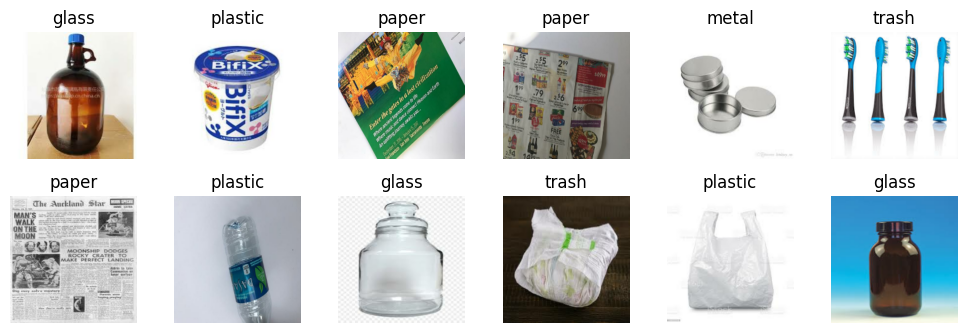

In [9]:
# ======================== Display Sample Images ========================
# Visualizing some of the training images with their labels
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(12):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.tight_layout()
plt.savefig('sample_images.png', dpi=300)  # Save in high definition

# **Build the Model**

In [10]:
# ======================== Build the Eco_Fri_NN Model ========================
# Building a model using EfficientNetV2B1 base
base_model = tf.keras.applications.EfficientNetV2B1(
    input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False   # Freeze this base model to avoid affecting pretrained weights

# Constructing the enhanced model

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.1)
])
# building the model
eco_fri_nn = models.Sequential([
    base_model,
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),

    layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    layers.Dense(len(class_names), activation='softmax')
])

28456008/28456008 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


# **Train the Model**

In [11]:
# ======================== Compile and Train the Proposed Model ========================
# Define callbacks for saving the best model and stopping early if needed
checkpoint = ModelCheckpoint("best_eco_fri_nn_model.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True)

# Compile the model with Adam optimizer and sparse categorical cross-entropy loss
eco_fri_nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
hist_eco_fri_nn = eco_fri_nn.fit(train, epochs=30, validation_data=validation, callbacks=[checkpoint, early_stopping])

Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 459s 5s/step - accuracy: 0.5864 - loss: 3.2663 - val_accuracy: 0.9339 - val_loss: 2.3596
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.8978 - loss: 2.3930 - val_accuracy: 0.9666 - val_loss: 2.1213
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.9221 - loss: 2.1797 - val_accuracy: 0.9769 - val_loss: 1.9547
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.9341 - loss: 2.0235 - val_accuracy: 0.9761 - val_loss: 1.8162
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.9448 - loss: 1.8689 - val_accuracy: 0.9817 - val_loss: 1.6797
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 0.9552 - loss: 1.7137 - val_accuracy: 0.9817 - val_loss: 1.5524
Epoch 7/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.9626 - loss: 1.5781 - val_accuracy: 0.9841 - val_loss: 1.4295
Epoch 8/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.9653 - loss: 1.4604 - val_accuracy

# **Fine tuning the Model**

In [12]:
# Load base model
base_model = tf.keras.applications.EfficientNetV2B1(
    input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = True  # Fine-tune top layers

# Freeze all layers except top 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

eco_fri_nn = models.Sequential([
    base_model,
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),

    layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    layers.Dense(len(class_names), activation='softmax')
])

# ======================== Compile and Train the Proposed Model ========================
# Define callbacks for saving the best model and stopping early if needed
checkpoint = ModelCheckpoint("best_eco_fri_nn_model.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True)

# Compile the model with Adam optimizer and sparse categorical cross-entropy loss
eco_fri_nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
hist_eco_fri_nn = eco_fri_nn.fit(train, epochs=30, validation_data=validation, callbacks=[checkpoint, early_stopping])

Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 79s 518ms/step - accuracy: 0.5754 - loss: 3.3222 - val_accuracy: 0.9506 - val_loss: 2.3253
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.9097 - loss: 2.3521 - val_accuracy: 0.9745 - val_loss: 2.0791
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.9451 - loss: 2.1018 - val_accuracy: 0.9825 - val_loss: 1.8978
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.9582 - loss: 1.9263 - val_accuracy: 0.9833 - val_loss: 1.7363
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.9680 - loss: 1.7465 - val_accuracy: 0.9896 - val_loss: 1.5758
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.9756 - loss: 1.5691 - val_accuracy: 0.9849 - val_loss: 1.4280
Epoch 7/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.9819 - loss: 1.4205 - val_accuracy: 0.9904 - val_loss: 1.2833
Epoch 8/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.9869 - loss: 1.2629 - val_accu

# **Model Summary**

In [13]:
# Model Architecture
eco_fri_nn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b1 (Functional)  │ (None, 7, 7, 1280)     │     6,931,124 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 1280)     │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,191,688 (57.95 MB)

 Trainable params: 3,139,430 (11.98 MB)

 Non-trainable params: 5,773,396 (22.02 MB)

 Optimizer params: 6,278,862 (23.95 MB)

# **Saving Training History**

In [14]:
# Save Training History
hist_eco_fri_nn_df = pd.DataFrame(hist_eco_fri_nn.history)
print("Training History:")
print(hist_eco_fri_nn_df)

Training History:
    accuracy      loss  val_accuracy  val_loss
0   0.742590  2.860216      0.950637  2.325295
1   0.914661  2.296001      0.974522  2.079132
2   0.948677  2.061218      0.982484  1.897780
3   0.959021  1.888114      0.983280  1.736320
4   0.969167  1.708824      0.989650  1.575759
5   0.975731  1.539324      0.984873  1.428018
6   0.979312  1.389115      0.990446  1.283335
7   0.983688  1.240564      0.989650  1.153644
8   0.982097  1.120559      0.992834  1.030463
9   0.981898  1.005058      0.988854  0.938555
10  0.979511  0.910750      0.988057  0.842649
11  0.983489  0.816159      0.990446  0.743740
12  0.985478  0.724707      0.988854  0.677513
13  0.987070  0.646904      0.990446  0.594525
14  0.987269  0.570009      0.988854  0.538804
15  0.982892  0.531336      0.988854  0.490400
16  0.985677  0.474043      0.987261  0.445712
17  0.988263  0.418966      0.988854  0.400958
18  0.988064  0.382970      0.986465  0.375543
19  0.983290  0.365890      0.987261  0.35

# **Model Evaluation**

In [15]:
# ======================== Evaluate Proposed Model on Validation Data ========================
# Prepare validation data for evaluation
X_val, y_val, y_pred = [], [], []
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())

# Get predictions from the model
predictions = eco_fri_nn.predict(np.array(X_val))
y_pred = [np.argmax(i) for i in predictions]

# Create Results DataFrame to compare true labels with predictions
results_df = pd.DataFrame()
results_df['Actual'] = y_val
results_df['Prediction'] = y_pred
print("Predictions vs Actual Labels:")
print(results_df)

40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 240ms/step
Predictions vs Actual Labels:
      Actual  Prediction
0          2           2
1          4           4
2          3           3
3          2           2
4          0           0
...      ...         ...
1251       5           5
1252       0           0
1253       5           5
1254       1           1
1255       1           1

[1256 rows x 2 columns]


# **Performance Curves**

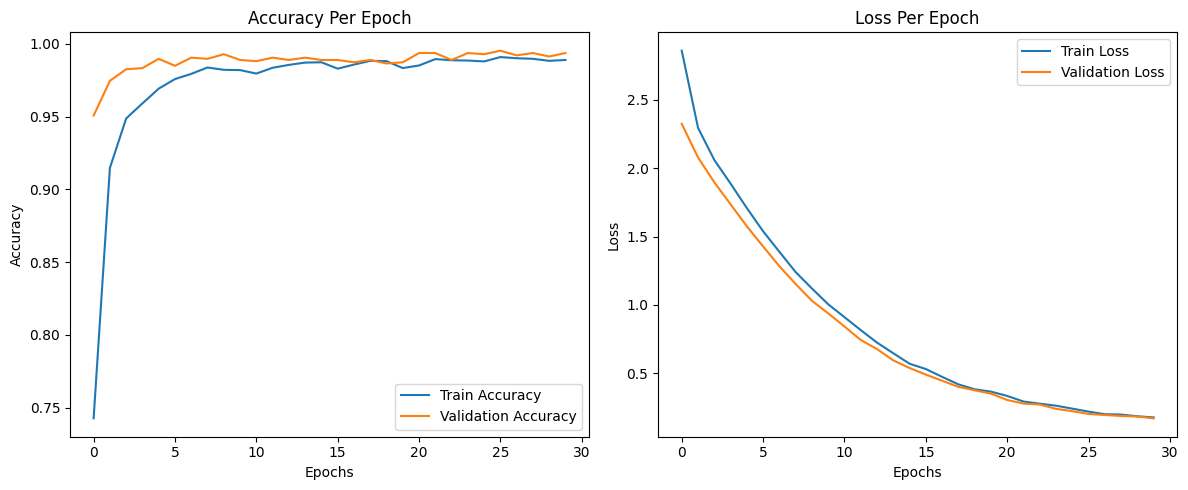

In [16]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(hist_eco_fri_nn_df['accuracy'], label='Train Accuracy')
plt.plot(hist_eco_fri_nn_df['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Per Epoch')

plt.subplot(1, 2, 2)
plt.plot(hist_eco_fri_nn_df['loss'], label='Train Loss')
plt.plot(hist_eco_fri_nn_df['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Per Epoch')

plt.tight_layout()
plt.savefig('accuracy_loss_per_epoch.png', dpi=300)  # Save in high definition

# **ROC Curve**

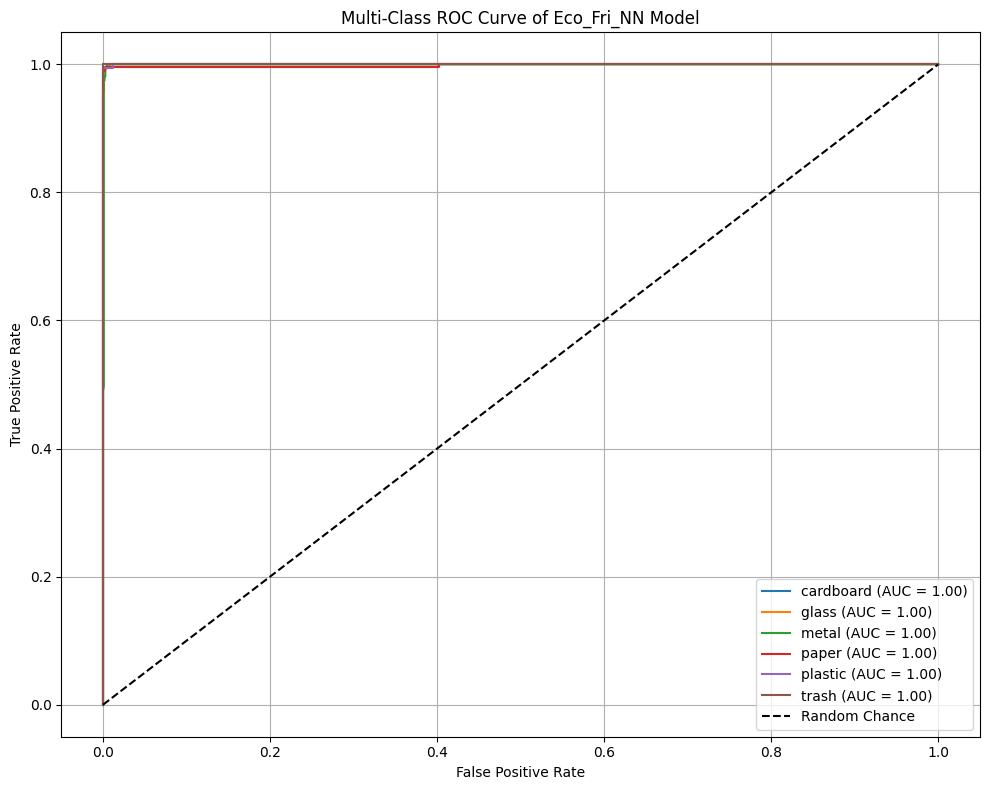

In [17]:
# Binarize the true labels for multi-class ROC
y_val_bin = label_binarize(y_val, classes=list(range(len(class_names))))

# Get predicted probabilities for each class
y_pred_probs = predictions  # already contains softmax outputs for each class

# Compute ROC curve and AUC for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_pred_probs[:, i])
    auc = roc_auc_score(y_val_bin[:, i], y_pred_probs[:, i])
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.title('Multi-Class ROC Curve of Eco_Fri_NN Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('multi_class_roc_curve.png', dpi=300)
plt.show()

# **Confusion Matrix**

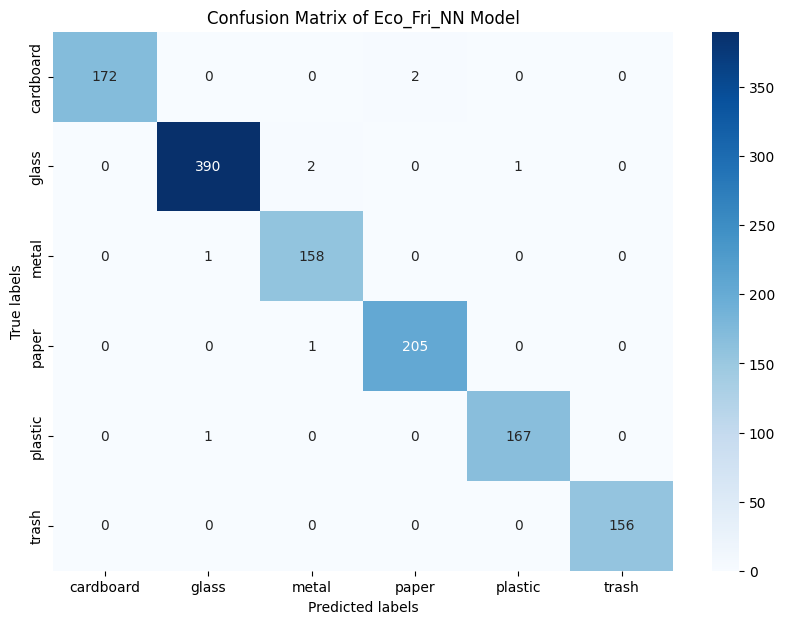

In [18]:
# ======================== Confusion Matrix ========================
# Create confusion matrix to assess model predictions
CM = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(CM, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix of Eco_Fri_NN Model')
plt.savefig('confusion_matrix.png', dpi=300)  # Save in high definition

# **Performance Matrix**

In [19]:
# ======================== Metrics Calculation ========================
# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

# Generate and display a classification report
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, target_names=class_names))

Accuracy: 99.36%
Precision: 99.37%
Recall: 99.36%
F1 Score: 99.36%
Mean Absolute Error: 0.0127
Root Mean Square Error (RMSE): 0.1785

Classification Report:

              precision    recall  f1-score   support

   cardboard       1.00      0.99      0.99       174
       glass       0.99      0.99      0.99       393
       metal       0.98      0.99      0.99       159
       paper       0.99      1.00      0.99       206
     plastic       0.99      0.99      0.99       168
       trash       1.00      1.00      1.00       156

    accuracy                           0.99      1256
   macro avg       0.99      0.99      0.99      1256
weighted avg       0.99      0.99      0.99      1256



# **Output**

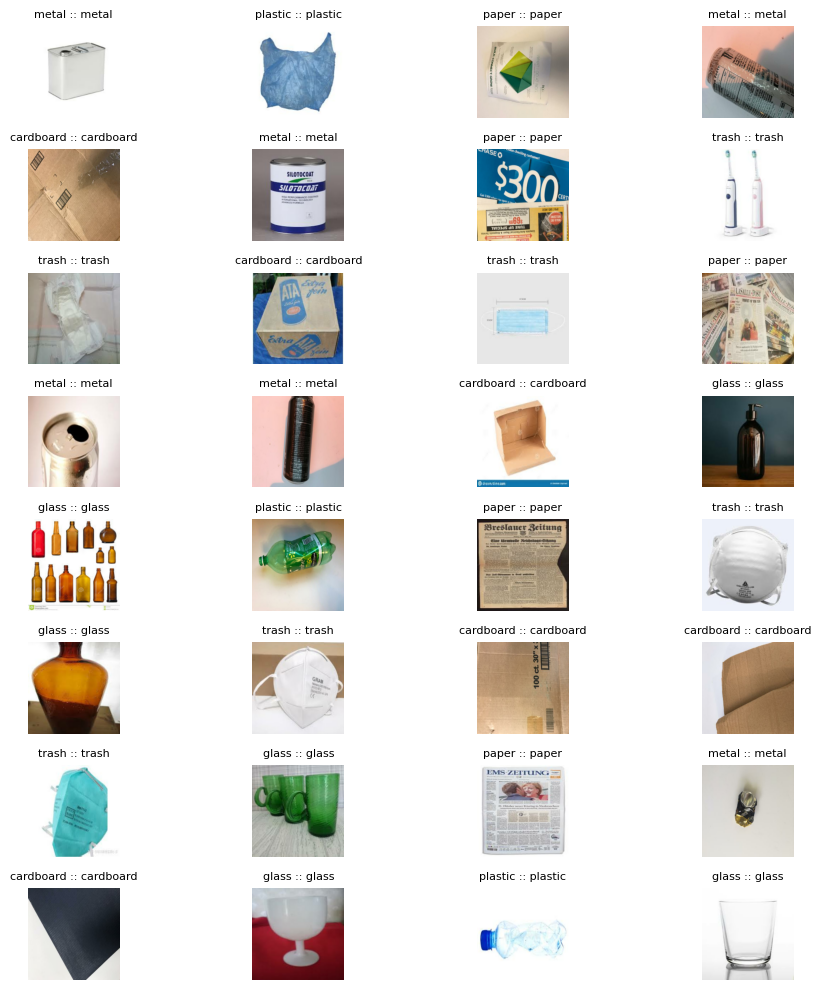

In [20]:
# ======================== Show Images with Predictions ========================
# Visualizing predictions against actual labels
plt.figure(figsize=(10, 10))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{class_names[y_val[i]]} :: {class_names[y_pred[i]]}', fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.savefig('predictions_vs_actual_images.png', dpi=300)  # Save in high definition

# **Model Saving**

In [21]:
# ======================== Save the Proposed Model ========================
# Save the trained model
eco_fri_nn.save('eco_fri_nn_model.keras')
print("Model Saved Successfully.")

Model Saved Successfully.


# **Adding XAI**

Using layer 'top_conv' for Grad-CAM.


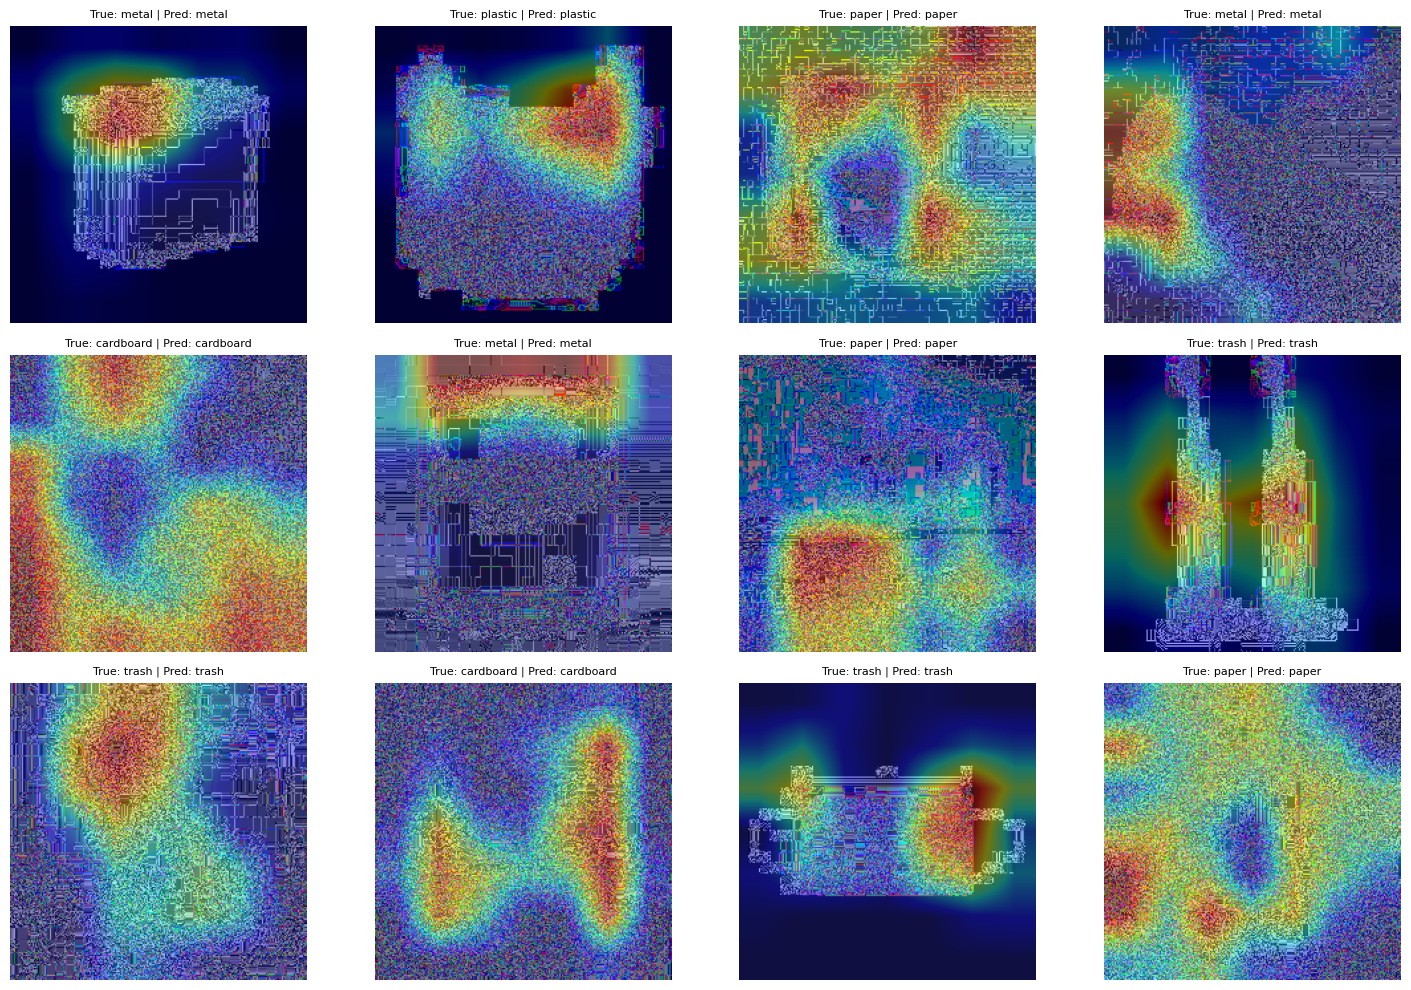

In [22]:
# ======================== Grad-CAM for Explainability ========================
import tensorflow.keras.backend as K
import cv2
import matplotlib.cm as cm

# Step 1: Extract base_model (EfficientNetV2B1) from your Sequential model
base_model = eco_fri_nn.layers[0]

# Step 2: Identify the last Conv2D layer in EfficientNetV2B1
last_conv_layer_name = None
for layer in reversed(base_model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break

if last_conv_layer_name is None:
    raise ValueError("No Conv2D layer found in EfficientNetV2B1.")

print(f"Using layer '{last_conv_layer_name}' for Grad-CAM.")

# Step 3: Grad-CAM utility functions

# Preprocess single image
def get_img_array(img):
    img = tf.image.resize(img, target_size)
    img = tf.expand_dims(img, axis=0)
    return img

# Generate Grad-CAM heatmap
def make_gradcam_heatmap(img_array, base_model, classifier_model, last_conv_layer_name, pred_index=None):
    # Get the output of the last conv layer
    grad_model = tf.keras.models.Model(
        [base_model.input],
        [base_model.get_layer(last_conv_layer_name).output, base_model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, base_output = grad_model(img_array)
        x = base_output
        # Forward pass through the rest of the model (excluding base_model)
        for layer in classifier_model.layers[1:]:  # Skip the base_model at index 0
            x = layer(x)
        preds = x

        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap + 1e-10)
    return heatmap.numpy()

# Overlay heatmap on image
def show_gradcam(img, heatmap, alpha=0.4):
    # If img is a NumPy array, no need for .numpy()
    if isinstance(img, tf.Tensor):
        img = img.numpy()
    img = (img * 255).astype(np.uint8)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    jet = cm.get_cmap("jet")
    jet_colors = jet(heatmap)
    jet_heatmap = (jet_colors[:, :, :3] * 255).astype(np.uint8)

    # Ensure image is RGB
    if img.shape[-1] == 1:  # grayscale to RGB
        img = np.repeat(img, 3, axis=-1)

    superimposed_img = cv2.addWeighted(img, 1 - alpha, jet_heatmap, alpha, 0)
    return superimposed_img


# ======================== Generate Grad-CAM for First 12 Validation Images ========================
plt.figure(figsize=(15, 10))
for i in range(12):
    img = X_val[i]
    label = y_val[i]
    pred = y_pred[i]

    img_array = get_img_array(img)

    heatmap = make_gradcam_heatmap(
        img_array,
        base_model=base_model,
        classifier_model=eco_fri_nn,
        last_conv_layer_name=last_conv_layer_name
    )

    gradcam_img = show_gradcam(img, heatmap)

    plt.subplot(3, 4, i + 1)
    plt.imshow(gradcam_img)
    plt.title(f"True: {class_names[label]} | Pred: {class_names[pred]}", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.savefig("gradcam_visualization.png", dpi=300)
plt.show()


# **MobileNetV2 + Transfer Learning**

Found 6283 files belonging to 6 classes.
Using 5027 files for training.
Found 6283 files belonging to 6 classes.
Using 1256 files for validation.
Class Names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Building the Model . . .
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Training the Model . . .
Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 277ms/step - accuracy: 0.4117 - loss: 3.6889 - val_accuracy: 0.6863 - val_loss: 2.9850
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.6533 - loss: 3.0315 - val_accuracy: 0.7508 - val_loss: 2.7171
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.7014 - loss: 2.7858 - val_accuracy: 0.8073 - val_loss: 2.5116
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.7539 - loss: 2.6032 - val_accuracy: 0.8352 - val_loss: 2.3341
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.7832 - loss: 2.4451 - val_accuracy: 0.8543 - val_loss: 2.1935
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 7, 7, 1280)     │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,243,604 (42.89 MB)

 Trainable params: 3,501,958 (13.36 MB)

 Non-trainable params: 737,728 (2.81 MB)

 Optimizer params: 7,003,918 (26.72 MB)

Save training history
Training History:
    accuracy      loss  val_accuracy  val_loss
0   0.554207  3.381838      0.363854  4.956077
1   0.752735  2.750318      0.509554  4.676748
2   0.843843  2.391109      0.371019  6.661808
3   0.903322  2.116601      0.427548  4.797552
4   0.936941  1.891747      0.347930  6.409348
5   0.948478  1.714601      0.523885  3.924912
6   0.948876  1.581297      0.513535  4.316761
7   0.963199  1.411727      0.353503  7.201199
8   0.969763  1.265133      0.517516  4.121948
9   0.969763  1.142004      0.380573  7.884916
10  0.963398  1.056139      0.605892  3.248900
11  0.973344  0.919833      0.698248  2.344438
12  0.977322  0.811752      0.604299  2.880270
13  0.983091  0.715748      0.793790  1.656755
14  0.979908  0.644606      0.816083  1.323628
15  0.980903  0.575379      0.660828  2.617486
16  0.984285  0.500468      0.683917  2.584815
17  0.975731  0.476169      0.791401  1.539902
18  0.972349  0.442243      0.800159  1.296136
19  0.981699  0.3722

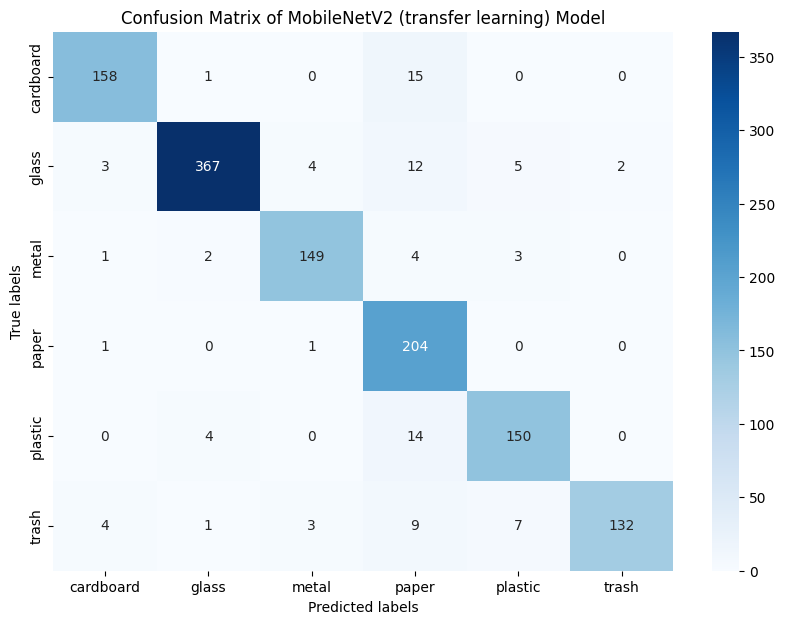

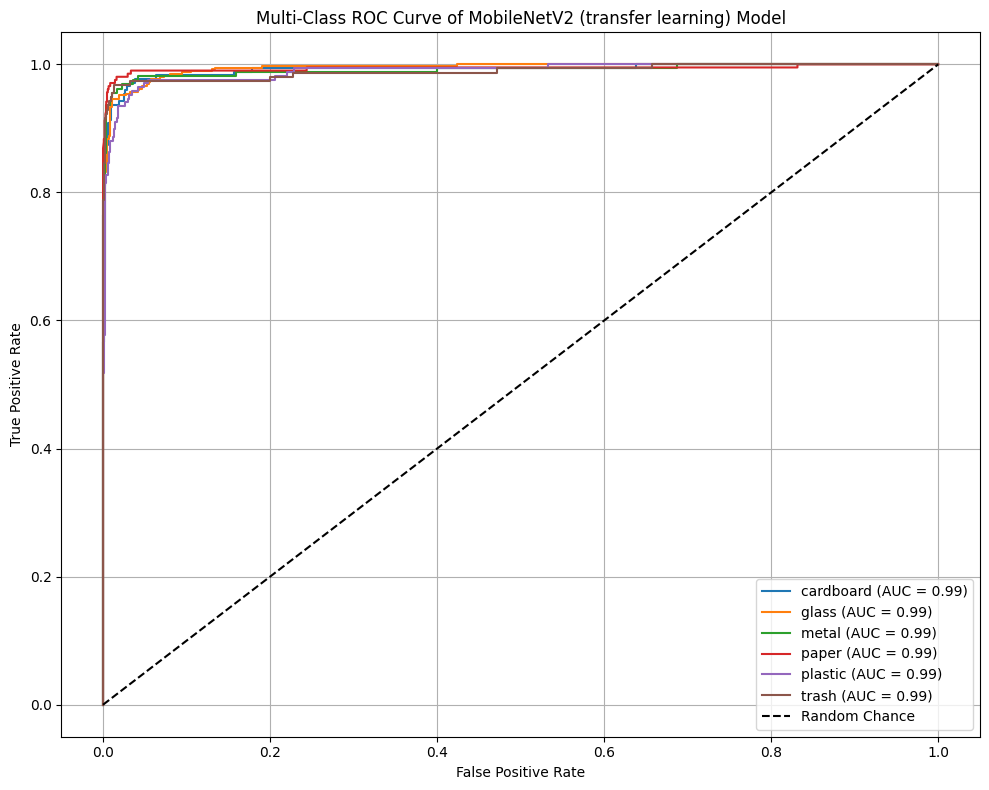

Performance Matrix
Accuracy: 92.36%
Precision: 93.11%
Recall: 92.36%
F1 Score: 92.46%
Mean Absolute Error: 0.1608
Root Mean Square Error (RMSE): 0.6533

Classification Report:

              precision    recall  f1-score   support

   cardboard       0.95      0.91      0.93       174
       glass       0.98      0.93      0.96       393
       metal       0.95      0.94      0.94       159
       paper       0.79      0.99      0.88       206
     plastic       0.91      0.89      0.90       168
       trash       0.99      0.85      0.91       156

    accuracy                           0.92      1256
   macro avg       0.93      0.92      0.92      1256
weighted avg       0.93      0.92      0.92      1256



In [23]:
# ======================== Dataset Preparation ========================
# Set parameters for image processing
target_size = (224, 224)             # Image size that the model requires
batch_size = 64                      # Number of images used in each training step
validation_split = 0.2               # Portion of data used for validation

# Create training and validation datasets
train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="training",
    seed=50,                         # Ensures reproducible results
    image_size=target_size,
    batch_size=batch_size,
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="validation",
    seed=100,                        # Different seed for validation to randomize differently
    image_size=target_size,
    batch_size=batch_size,
)

# Class names
class_names = train.class_names
print("Class Names:", class_names)

print("Building the Model . . .")

# ======================== Build the MobileNetV2 + Transfer Learning Model ========================
# Building a model using MobileNetV2 base
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False   # Freeze this base model to avoid affecting pretrained weights

# Constructing the enhanced model

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.1)
])
# building the model
T_MobileNetV2 = models.Sequential([
    base_model,
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),

    layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    layers.Dense(len(class_names), activation='softmax')
])

print("Training the Model . . .")

# ======================== Compile and Train the Model ========================
# Define callbacks for saving the best model and stopping early if needed
checkpoint = ModelCheckpoint("best_T_MobileNetV2_model.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True)

# Compile the model with Adam optimizer and sparse categorical cross-entropy loss
T_MobileNetV2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
hist_tmobilenet = T_MobileNetV2.fit(train, epochs=30, validation_data=validation)

print('Fine Tuning the Model . . .')

# Load base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = True  # Fine-tune top layers

# Freeze all layers except top 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

T_MobileNetV2 = models.Sequential([
    base_model,
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),

    layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    layers.Dense(len(class_names), activation='softmax')
])

# ======================== Compile and Train the Proposed Model ========================
# Define callbacks for saving the best model and stopping early if needed
checkpoint = ModelCheckpoint("best_T_MobileNetV2_model.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True)

# Compile the model with Adam optimizer and sparse categorical cross-entropy loss
T_MobileNetV2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
hist_tmobilenet = T_MobileNetV2.fit(train, epochs=30, validation_data=validation)

print("Summarize the Model")

# Model Architecture
T_MobileNetV2.summary()

print("Save training history")

# Save Training History
hist_tmobilenet_df = pd.DataFrame(hist_tmobilenet.history)
print("Training History:")
print(hist_tmobilenet_df)

print("Evaluate the Model")

# ======================== Evaluate T_MobileNetV2 Model on Validation Data ========================
# Prepare validation data for evaluation
X_val, y_val, y_pred = [], [], []
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())

# Get predictions from the model
predictions = T_MobileNetV2.predict(np.array(X_val))
y_pred = [np.argmax(i) for i in predictions]

# Create Results DataFrame to compare true labels with predictions
results_df = pd.DataFrame()
results_df['Actual'] = y_val
results_df['Prediction'] = y_pred
print("Predictions vs Actual Labels:")
print(results_df)

print("Confusion Matrix")

# ======================== Confusion Matrix ========================
# Create confusion matrix to assess model predictions
CM = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(CM, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix of MobileNetV2 (transfer learning) Model')
plt.savefig('confusion_matrix_MobileNetV2Transfer.png', dpi=300)  # Save in high definition

print("ROC Curve")

# ======================== ROC Curve ========================
# Binarize the true labels for multi-class ROC
y_val_bin = label_binarize(y_val, classes=list(range(len(class_names))))

# Get predicted probabilities for each class
y_pred_probs = predictions  # already contains softmax outputs for each class

# Compute ROC curve and AUC for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_pred_probs[:, i])
    auc = roc_auc_score(y_val_bin[:, i], y_pred_probs[:, i])
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.title('Multi-Class ROC Curve of MobileNetV2 (transfer learning) Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('multi_class_roc_curve_MobileNetV2Transfer.png', dpi=300)
plt.show()

print("Performance Matrix")

# ======================== Metrics Calculation ========================
# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

# Generate and display a classification report
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, target_names=class_names))

# **VGG19 + Transfer Learning**

Found 6283 files belonging to 6 classes.
Using 5027 files for training.
Found 6283 files belonging to 6 classes.
Using 1256 files for validation.
Class Names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Building the Model . . .
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Training the Model . . .
Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 99s 896ms/step - accuracy: 0.4679 - loss: 3.1115 - val_accuracy: 0.8439 - val_loss: 2.2686
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 39s 497ms/step - accuracy: 0.7983 - loss: 2.2298 - val_accuracy: 0.8893 - val_loss: 1.9904
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 38s 485ms/step - accuracy: 0.8584 - loss: 2.0106 - val_accuracy: 0.9196 - val_loss: 1.8126
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 39s 492ms/step - accuracy: 0.8684 - loss: 1.8996 - val_accuracy: 0.9475 - val_loss: 1.6765
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 39s 491ms/step - accuracy: 0.8921 - loss: 1.7561 - val_accuracy: 0.9570 - val_loss: 1.5705
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 7, 7, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,640,532 (242.77 MB)

 Trainable params: 21,211,974 (80.92 MB)

 Non-trainable params: 4,608 (18.00 KB)

 Optimizer params: 42,423,950 (161.83 MB)

Save training history
Training History:
    accuracy      loss  val_accuracy  val_loss
0   0.347126  3.369751      0.215764  4.274639
1   0.425502  3.043823      0.241242  3.868010
2   0.462304  2.802028      0.261943  5.719264
3   0.474239  2.620352      0.196656  4.721441
4   0.501094  2.452718      0.421178  2.905557
5   0.564750  2.241669      0.446656  2.914885
6   0.592998  2.104988      0.422771  3.187369
7   0.614880  1.964416      0.554140  2.146377
8   0.646310  1.842044      0.557325  2.637640
9   0.664412  1.728957      0.512739  2.020595
10  0.670380  1.657054      0.629777  1.676894
11  0.703203  1.546976      0.667994  1.581470
12  0.719316  1.441268      0.570860  1.701675
13  0.714541  1.394549      0.601911  1.615109
14  0.734235  1.315032      0.679140  1.342718
15  0.742988  1.236627      0.648089  1.576358
16  0.745176  1.190652      0.742834  1.215349
17  0.759300  1.126624      0.666401  1.598566
18  0.777999  1.054497      0.771497  1.046591
19  0.788343  0.9861

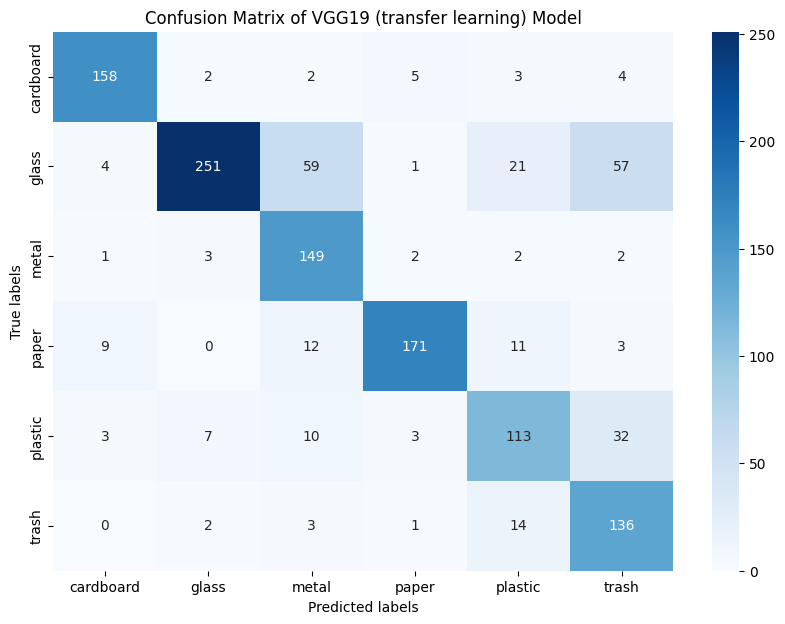

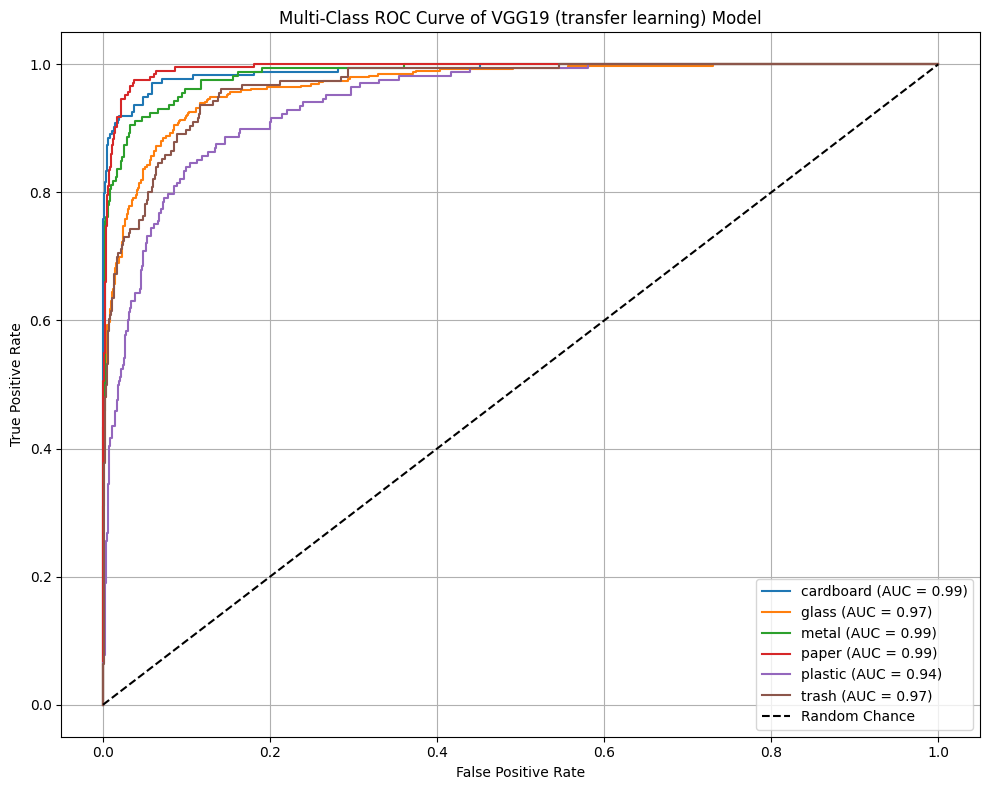

Performance Matrix
Accuracy: 77.87%
Precision: 81.93%
Recall: 77.87%
F1 Score: 78.18%
Mean Absolute Error: 0.4801
Root Mean Square Error (RMSE): 1.1921

Classification Report:

              precision    recall  f1-score   support

   cardboard       0.90      0.91      0.91       174
       glass       0.95      0.64      0.76       393
       metal       0.63      0.94      0.76       159
       paper       0.93      0.83      0.88       206
     plastic       0.69      0.67      0.68       168
       trash       0.58      0.87      0.70       156

    accuracy                           0.78      1256
   macro avg       0.78      0.81      0.78      1256
weighted avg       0.82      0.78      0.78      1256



In [24]:
# ======================== Dataset Preparation ========================
# Set parameters for image processing
target_size = (224, 224)             # Image size that the model requires
batch_size = 64                      # Number of images used in each training step
validation_split = 0.2               # Portion of data used for validation

# Create training and validation datasets
train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="training",
    seed=50,                         # Ensures reproducible results
    image_size=target_size,
    batch_size=batch_size,
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="validation",
    seed=100,                        # Different seed for validation to randomize differently
    image_size=target_size,
    batch_size=batch_size,
)

# Class names
class_names = train.class_names
print("Class Names:", class_names)

print("Building the Model . . .")

# ======================== Build the VGG19 + Transfer Learning Model ========================
# Building a model using VGG19 base
base_model = tf.keras.applications.VGG19(
    input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False   # Freeze this base model to avoid affecting pretrained weights

# Constructing the enhanced model

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.1)
])
# building the model
T_VGG19 = models.Sequential([
    base_model,
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),

    layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    layers.Dense(len(class_names), activation='softmax')
])

print("Training the Model . . .")

# ======================== Compile and Train the Model ========================
# Define callbacks for saving the best model and stopping early if needed
checkpoint = ModelCheckpoint("best_T_VGG19_model.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True)

# Compile the model with Adam optimizer and sparse categorical cross-entropy loss
T_VGG19.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
hist_tvgg19 = T_VGG19.fit(train, epochs=30, validation_data=validation)

print('Fine Tuning the Model . . .')

# Load base model
base_model = tf.keras.applications.VGG19(
    input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = True  # Fine-tune top layers

# Freeze all layers except top 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

T_VGG19 = models.Sequential([
    base_model,
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),

    layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    layers.Dense(len(class_names), activation='softmax')
])

# ======================== Compile and Train the Model ========================
# Define callbacks for saving the best model and stopping early if needed
checkpoint = ModelCheckpoint("best_T_VGG19_model.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True)

# Compile the model with Adam optimizer and sparse categorical cross-entropy loss
T_VGG19.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
hist_tvgg19 = T_VGG19.fit(train, epochs=30, validation_data=validation)

print("Summarize the Model")

# Model Architecture
T_VGG19.summary()

print("Save training history")

# Save Training History
hist_tvgg19_df = pd.DataFrame(hist_tvgg19.history)
print("Training History:")
print(hist_tvgg19_df)

print("Evaluate the Model")

# ======================== Evaluate VGG19 + Transfer Learning Model on Validation Data ========================
# Prepare validation data for evaluation
X_val, y_val, y_pred = [], [], []
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())

# Get predictions from the model
predictions = T_VGG19.predict(np.array(X_val))
y_pred = [np.argmax(i) for i in predictions]

# Create Results DataFrame to compare true labels with predictions
results_df = pd.DataFrame()
results_df['Actual'] = y_val
results_df['Prediction'] = y_pred
print("Predictions vs Actual Labels:")
print(results_df)

print("Confusion Matrix")

# ======================== Confusion Matrix ========================
# Create confusion matrix to assess model predictions
CM = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(CM, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix of VGG19 (transfer learning) Model')
plt.savefig('confusion_matrix_VGG19Transfer.png', dpi=300)  # Save in high definition

print("ROC Curve")

# Binarize the true labels for multi-class ROC
y_val_bin = label_binarize(y_val, classes=list(range(len(class_names))))

# Get predicted probabilities for each class
y_pred_probs = predictions  # already contains softmax outputs for each class

# Compute ROC curve and AUC for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_pred_probs[:, i])
    auc = roc_auc_score(y_val_bin[:, i], y_pred_probs[:, i])
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.title('Multi-Class ROC Curve of VGG19 (transfer learning) Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('multi_class_roc_curve_VGG19Transfer.png', dpi=300)
plt.show()

print("Performance Matrix")

# ======================== Metrics Calculation ========================
# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

# Generate and display a classification report
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, target_names=class_names))

# **ResNet50 + Transfer Learning**

Found 6283 files belonging to 6 classes.
Using 5027 files for training.
Found 6283 files belonging to 6 classes.
Using 1256 files for validation.
Class Names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Building the Model . . .
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Training the Model . . .
Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 53s 445ms/step - accuracy: 0.5590 - loss: 3.5687 - val_accuracy: 0.8869 - val_loss: 2.6758
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 222ms/step - accuracy: 0.8547 - loss: 2.7134 - val_accuracy: 0.9379 - val_loss: 2.4043
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 218ms/step - accuracy: 0.9165 - loss: 2.4453 - val_accuracy: 0.9570 - val_loss: 2.2223
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 216ms/step - accuracy: 0.9231 - loss: 2.2631 - val_accuracy: 0.9777 - val_loss: 2.0392
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 221ms/step - accuracy: 0.9518 - loss: 2.0627 - val_accuracy: 0.9825 - val_loss: 1.8930
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 7, 7, 2048)     │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,786,324 (231.88 MB)

 Trainable params: 17,213,702 (65.67 MB)

 Non-trainable params: 9,145,216 (34.89 MB)

 Optimizer params: 34,427,406 (131.33 MB)

Save training history
Training History:
    accuracy      loss  val_accuracy  val_loss
0   0.766660  3.016983      0.871019  2.715458
1   0.930177  2.408896      0.941879  2.317683
2   0.958425  2.119648      0.949045  2.089752
3   0.970360  1.857176      0.965764  1.776269
4   0.973941  1.619601      0.967357  1.556695
5   0.977720  1.402813      0.959395  1.380608
6   0.981699  1.207125      0.980892  1.128789
7   0.977124  1.052289      0.983280  0.996729
8   0.984484  0.891547      0.980892  0.860746
9   0.985478  0.755687      0.984873  0.709989
10  0.988860  0.638538      0.984873  0.620692
11  0.986871  0.559954      0.979299  0.564835
12  0.985280  0.485598      0.977707  0.490352
13  0.987866  0.418136      0.986465  0.411620
14  0.989258  0.352558      0.980892  0.368452
15  0.992441  0.299048      0.985669  0.321050
16  0.994629  0.253955      0.984873  0.284540
17  0.983290  0.255615      0.976115  0.316831
18  0.989656  0.217425      0.986465  0.233491
19  0.990650  0.1991

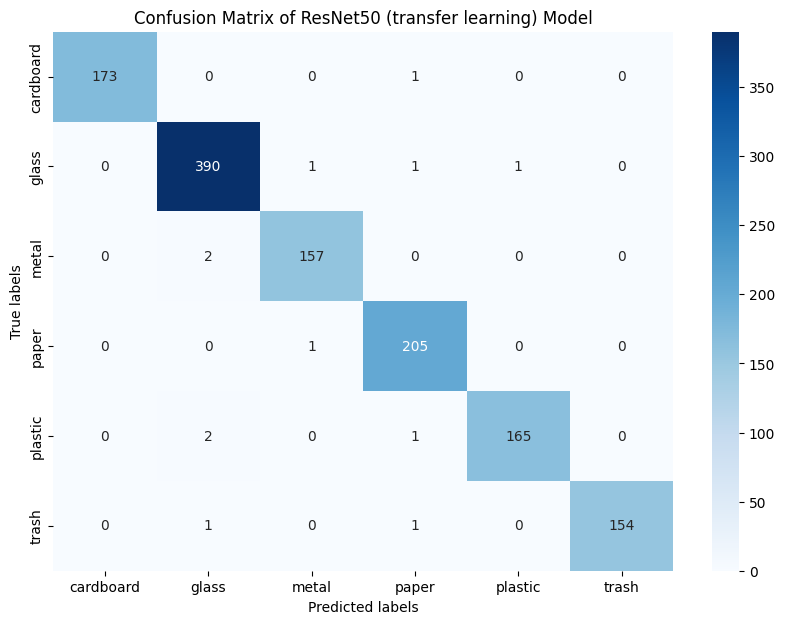

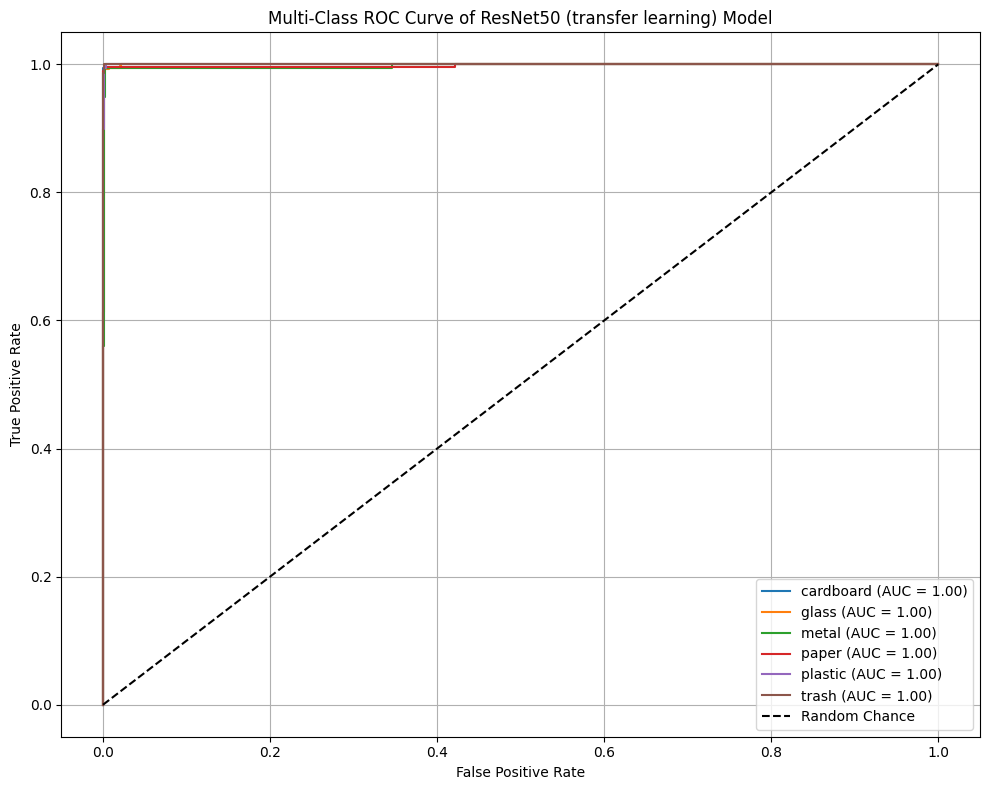

Performance Matrix
Accuracy: 99.04%
Precision: 99.05%
Recall: 99.04%
F1 Score: 99.05%
Mean Absolute Error: 0.0199
Root Mean Square Error (RMSE): 0.2275

Classification Report:

              precision    recall  f1-score   support

   cardboard       1.00      0.99      1.00       174
       glass       0.99      0.99      0.99       393
       metal       0.99      0.99      0.99       159
       paper       0.98      1.00      0.99       206
     plastic       0.99      0.98      0.99       168
       trash       1.00      0.99      0.99       156

    accuracy                           0.99      1256
   macro avg       0.99      0.99      0.99      1256
weighted avg       0.99      0.99      0.99      1256



In [25]:
# ======================== Dataset Preparation ========================
# Set parameters for image processing
target_size = (224, 224)             # Image size that the model requires
batch_size = 64                      # Number of images used in each training step
validation_split = 0.2               # Portion of data used for validation

# Create training and validation datasets
train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="training",
    seed=50,                         # Ensures reproducible results
    image_size=target_size,
    batch_size=batch_size,
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="validation",
    seed=100,                        # Different seed for validation to randomize differently
    image_size=target_size,
    batch_size=batch_size,
)

# Class names
class_names = train.class_names
print("Class Names:", class_names)

print("Building the Model . . .")

# ======================== Build the ResNet50 + Transfer Learning Model ========================
# Building a model using ResNet50 base
base_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False   # Freeze this base model to avoid affecting pretrained weights

# Constructing the enhanced model

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.1)
])
# building the model
T_ResNet50 = models.Sequential([
    base_model,
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),

    layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    layers.Dense(len(class_names), activation='softmax')
])

print("Training the Model . . .")

# ======================== Compile and Train the Proposed Model ========================
# Define callbacks for saving the best model and stopping early if needed
checkpoint = ModelCheckpoint("best_T_ResNet50_model.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True)

# Compile the model with Adam optimizer and sparse categorical cross-entropy loss
T_ResNet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
hist_tresnet = T_ResNet50.fit(train, epochs=30, validation_data=validation, callbacks=[checkpoint, early_stopping])

print('Fine Tuning the Model . . .')

# Load base model
base_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = True  # Fine-tune top layers

# Freeze all layers except top 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

T_ResNet50 = models.Sequential([
    base_model,
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),

    layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    layers.Dense(len(class_names), activation='softmax')
])

# ======================== Compile and Train the Proposed Model ========================
# Define callbacks for saving the best model and stopping early if needed
checkpoint = ModelCheckpoint("best_T_ResNet50_model.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True)

# Compile the model with Adam optimizer and sparse categorical cross-entropy loss
T_ResNet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
hist_tresnet = T_ResNet50.fit(train, epochs=30, validation_data=validation, callbacks=[checkpoint, early_stopping])

print("Summarize the Model")

# Model Architecture
T_ResNet50.summary()

print("Save training history")

# Save Training History
hist_tresnet_df = pd.DataFrame(hist_tresnet.history)
print("Training History:")
print(hist_tresnet_df)

print("Evaluate the Model")

# ======================== Evaluate ResNet50 + Transfer Learning Model on Validation Data ========================
# Prepare validation data for evaluation
X_val, y_val, y_pred = [], [], []
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())

# Get predictions from the model
predictions = T_ResNet50.predict(np.array(X_val))
y_pred = [np.argmax(i) for i in predictions]

# Create Results DataFrame to compare true labels with predictions
results_df = pd.DataFrame()
results_df['Actual'] = y_val
results_df['Prediction'] = y_pred
print("Predictions vs Actual Labels:")
print(results_df)

print("Confusion Matrix")

# ======================== Confusion Matrix ========================
# Create confusion matrix to assess model predictions
CM = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(CM, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix of ResNet50 (transfer learning) Model')
plt.savefig('confusion_matrix_ResNet50Transfer.png', dpi=300)  # Save in high definition

print("ROC Curve")

# Binarize the true labels for multi-class ROC
y_val_bin = label_binarize(y_val, classes=list(range(len(class_names))))

# Get predicted probabilities for each class
y_pred_probs = predictions  # already contains softmax outputs for each class

# Compute ROC curve and AUC for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_pred_probs[:, i])
    auc = roc_auc_score(y_val_bin[:, i], y_pred_probs[:, i])
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.title('Multi-Class ROC Curve of ResNet50 (transfer learning) Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('multi_class_roc_curve_ResNet50Transfer.png', dpi=300)
plt.show()

print("Performance Matrix")

# ======================== Metrics Calculation ========================
# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

# Generate and display a classification report
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, target_names=class_names))

# **EfficientNetB0 + Transfer Learning**

Found 6283 files belonging to 6 classes.
Using 5027 files for training.
Found 6283 files belonging to 6 classes.
Using 1256 files for validation.
Class Names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Building the Model . . .
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Training the Model . . .
Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 53s 389ms/step - accuracy: 0.5732 - loss: 3.3295 - val_accuracy: 0.9260 - val_loss: 2.3891
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.8906 - loss: 2.3952 - val_accuracy: 0.9586 - val_loss: 2.1394
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.9173 - loss: 2.1953 - val_accuracy: 0.9769 - val_loss: 1.9678
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.9348 - loss: 2.0329 - val_accuracy: 0.9817 - val_loss: 1.8152
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.9494 - loss: 1.8576 - val_accuracy: 0.9881 - val_loss: 1.6794
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 7, 7, 1280)     │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,974,711 (49.49 MB)

 Trainable params: 3,471,718 (13.24 MB)

 Non-trainable params: 2,559,555 (9.76 MB)

 Optimizer params: 6,943,438 (26.49 MB)

Save training history
Training History:
    accuracy      loss  val_accuracy  val_loss
0   0.715138  2.943113      0.933121  2.339514
1   0.925801  2.281615      0.970541  2.099836
2   0.953252  2.074855      0.983280  1.917922
3   0.965586  1.893537      0.988854  1.765899
4   0.979113  1.722373      0.989650  1.620118
5   0.985280  1.549918      0.991242  1.466782
6   0.987667  1.395781      0.992038  1.314511
7   0.986871  1.259730      0.989650  1.188147
8   0.991446  1.112288      0.990446  1.052983
9   0.990452  0.991218      0.988854  0.952171
10  0.986473  0.888827      0.990446  0.863382
11  0.985081  0.802096      0.992834  0.747267
12  0.991844  0.695223      0.989650  0.665007
13  0.987866  0.617491      0.990446  0.584240
14  0.987070  0.556486      0.988854  0.535861
15  0.990054  0.486017      0.993631  0.457764
16  0.988661  0.432032      0.987261  0.434071
17  0.989457  0.391153      0.992834  0.365891
18  0.993833  0.330640      0.990446  0.329027
19  0.989258  0.3067

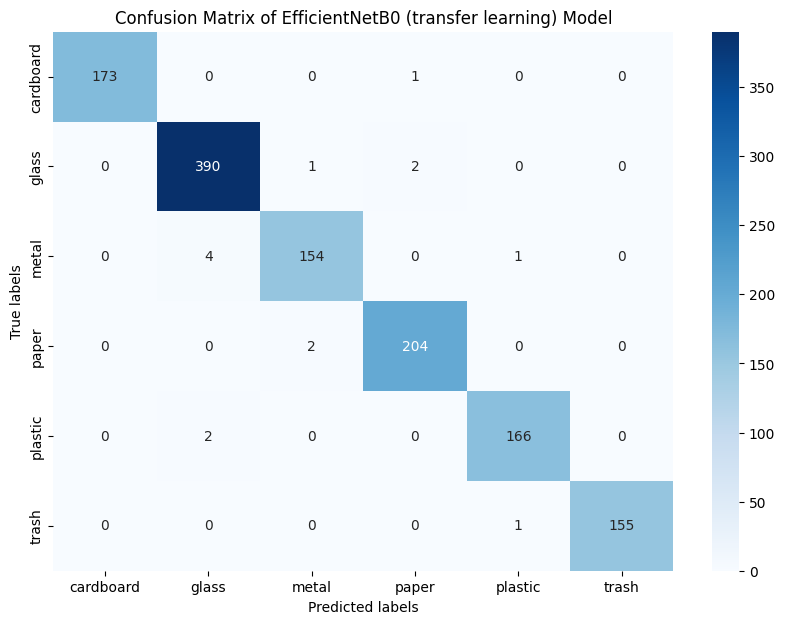

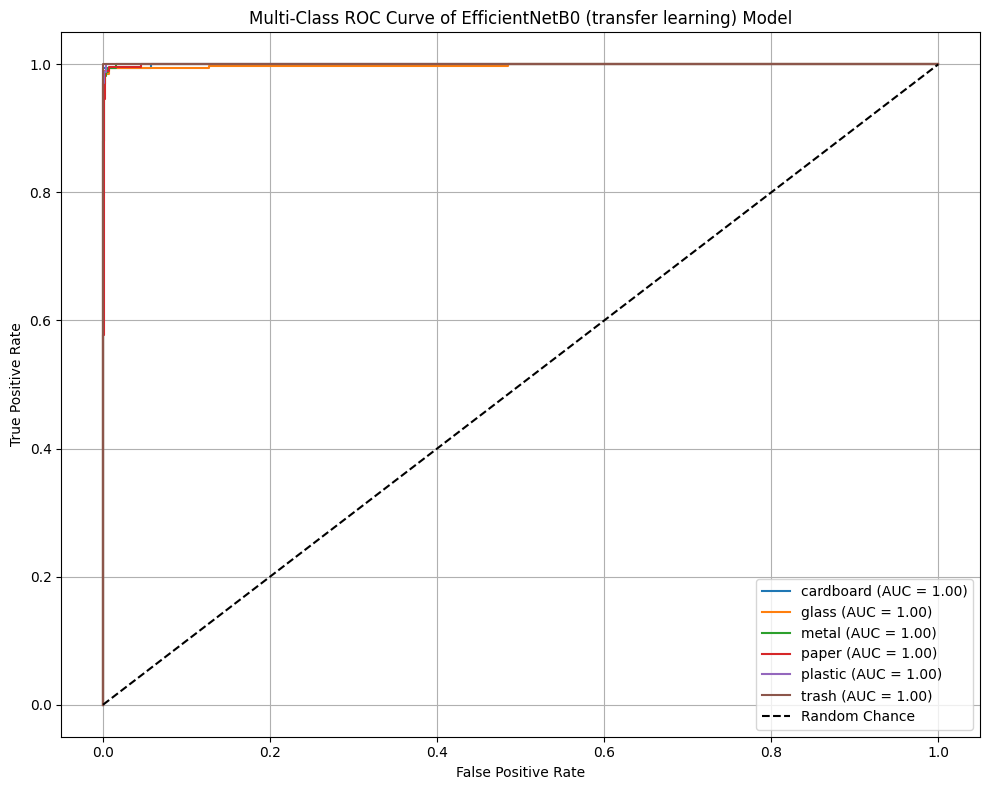

Performance Matrix
Accuracy: 98.89%
Precision: 98.89%
Recall: 98.89%
F1 Score: 98.88%
Mean Absolute Error: 0.0183
Root Mean Square Error (RMSE): 0.1934

Classification Report:

              precision    recall  f1-score   support

   cardboard       1.00      0.99      1.00       174
       glass       0.98      0.99      0.99       393
       metal       0.98      0.97      0.97       159
       paper       0.99      0.99      0.99       206
     plastic       0.99      0.99      0.99       168
       trash       1.00      0.99      1.00       156

    accuracy                           0.99      1256
   macro avg       0.99      0.99      0.99      1256
weighted avg       0.99      0.99      0.99      1256



In [26]:
# ======================== Dataset Preparation ========================
# Set parameters for image processing
target_size = (224, 224)             # Image size that the model requires
batch_size = 64                      # Number of images used in each training step
validation_split = 0.2               # Portion of data used for validation

# Create training and validation datasets
train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="training",
    seed=50,                         # Ensures reproducible results
    image_size=target_size,
    batch_size=batch_size,
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="validation",
    seed=100,                        # Different seed for validation to randomize differently
    image_size=target_size,
    batch_size=batch_size,
)

# Class names
class_names = train.class_names
print("Class Names:", class_names)

print("Building the Model . . .")

# ======================== Build the EfficientNetB0 + Transfer Learning Model ========================
# Building a model using EfficientNetB0 base
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False   # Freeze this base model to avoid affecting pretrained weights

# Constructing the enhanced model

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.1)
])
# building the model
T_EfficientNetB0 = models.Sequential([
    base_model,
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),

    layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    layers.Dense(len(class_names), activation='softmax')
])

print("Training the Model . . .")

# ======================== Compile and Train the Proposed Model ========================
# Define callbacks for saving the best model and stopping early if needed
checkpoint = ModelCheckpoint("best_T_EfficientNetB0_model.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True)

# Compile the model with Adam optimizer and sparse categorical cross-entropy loss
T_EfficientNetB0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
hist_tefficientnet = T_EfficientNetB0.fit(train, epochs=30, validation_data=validation, callbacks=[checkpoint, early_stopping])

print('Fine Tuning the Model . . .')

# Load base model
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = True  # Fine-tune top layers

# Freeze all layers except top 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

T_EfficientNetB0 = models.Sequential([
    base_model,
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),

    layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    layers.Dense(len(class_names), activation='softmax')
])

# ======================== Compile and Train the Proposed Model ========================
# Define callbacks for saving the best model and stopping early if needed
checkpoint = ModelCheckpoint("best_T_EfficientNetB0_model.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True)

# Compile the model with Adam optimizer and sparse categorical cross-entropy loss
T_EfficientNetB0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
hist_tefficientnet = T_EfficientNetB0.fit(train, epochs=30, validation_data=validation, callbacks=[checkpoint, early_stopping])

print("Summarize the Model")

# Model Architecture
T_EfficientNetB0.summary()

print("Save training history")

# Save Training History
hist_tefficientnet_df = pd.DataFrame(hist_tefficientnet.history)
print("Training History:")
print(hist_tefficientnet_df)

print("Evaluate the Model")

# ======================== Evaluate EfficientNetB0 + Transfer Learning Model on Validation Data ========================
# Prepare validation data for evaluation
X_val, y_val, y_pred = [], [], []
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())

# Get predictions from the model
predictions = T_EfficientNetB0.predict(np.array(X_val))
y_pred = [np.argmax(i) for i in predictions]

# Create Results DataFrame to compare true labels with predictions
results_df = pd.DataFrame()
results_df['Actual'] = y_val
results_df['Prediction'] = y_pred
print("Predictions vs Actual Labels:")
print(results_df)

print("Confusion Matrix")

# ======================== Confusion Matrix ========================
# Create confusion matrix to assess model predictions
CM = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(CM, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix of EfficientNetB0 (transfer learning) Model')
plt.savefig('confusion_matrix_EfficientNetB0Transfer.png', dpi=300)  # Save in high definition

print("ROC Curve")

# Binarize the true labels for multi-class ROC
y_val_bin = label_binarize(y_val, classes=list(range(len(class_names))))

# Get predicted probabilities for each class
y_pred_probs = predictions  # already contains softmax outputs for each class

# Compute ROC curve and AUC for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_pred_probs[:, i])
    auc = roc_auc_score(y_val_bin[:, i], y_pred_probs[:, i])
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.title('Multi-Class ROC Curve of EfficientNetB0 (transfer learning) Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('multi_class_roc_curve_EfficientNetB0Transfer.png', dpi=300)
plt.show()

print("Performance Matrix")

# ======================== Metrics Calculation ========================
# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

# Generate and display a classification report
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, target_names=class_names))

# **EfficientNetV2B1**

Found 6283 files belonging to 6 classes.
Using 5027 files for training.
Found 6283 files belonging to 6 classes.
Using 1256 files for validation.
Class Names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Building and Training the Model . . .
Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 57s 397ms/step - accuracy: 0.5501 - loss: 1.3075 - val_accuracy: 0.8678 - val_loss: 0.5409
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.8671 - loss: 0.5009 - val_accuracy: 0.9164 - val_loss: 0.3557
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.9002 - loss: 0.3642 - val_accuracy: 0.9283 - val_loss: 0.2842
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9178 - loss: 0.3063 - val_accuracy: 0.9339 - val_loss: 0.2456
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.9259 - loss: 0.2623 - val_accuracy: 0.9411 - val_loss: 0.2191
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.9269 - loss: 0.2424 - val_accuracy

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b1 (Functional)  │ (None, 1280)           │     6,931,124 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,954,184 (26.53 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 6,931,124 (26.44 MB)

 Optimizer params: 15,374 (60.06 KB)

Save training history
Training History:
    accuracy      loss  val_accuracy  val_loss
0   0.705192  0.977378      0.867834  0.540878
1   0.873881  0.466010      0.916401  0.355666
2   0.898548  0.352333      0.928344  0.284202
3   0.916451  0.296658      0.933917  0.245566
4   0.925005  0.260341      0.941083  0.219107
5   0.926397  0.241880      0.945064  0.201193
6   0.933957  0.217654      0.948248  0.186363
7   0.937338  0.210592      0.954618  0.174922
8   0.940919  0.196058      0.955414  0.166056
9   0.945494  0.181703      0.956210  0.157256
10  0.947682  0.176374      0.958599  0.149997
11  0.949672  0.166704      0.961783  0.144094
12  0.949672  0.162539      0.964968  0.137623
13  0.955441  0.152821      0.965764  0.132797
14  0.956435  0.144447      0.965764  0.128274
15  0.958822  0.139890      0.967357  0.123688
16  0.958822  0.136615      0.969745  0.119588
17  0.961607  0.135518      0.969745  0.115341
18  0.959419  0.131715      0.968949  0.112622
19  0.961806  0.1256

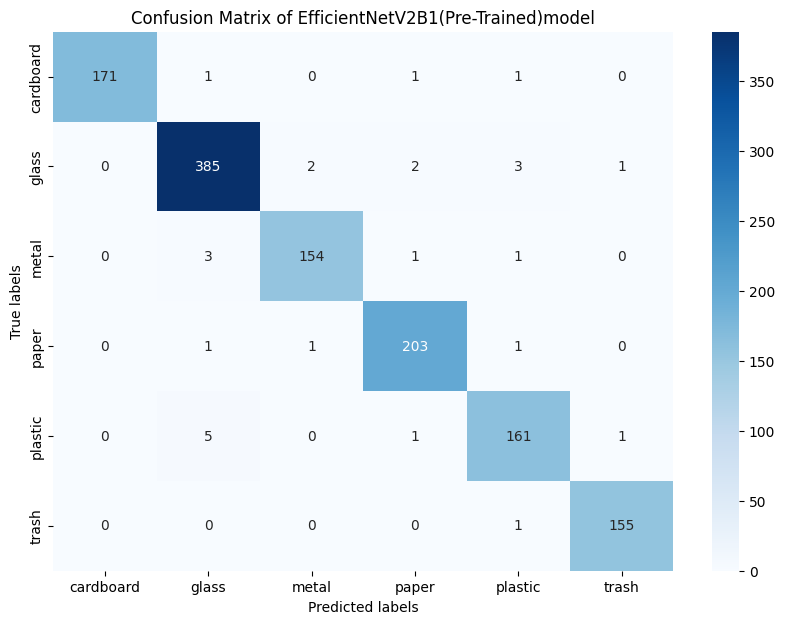

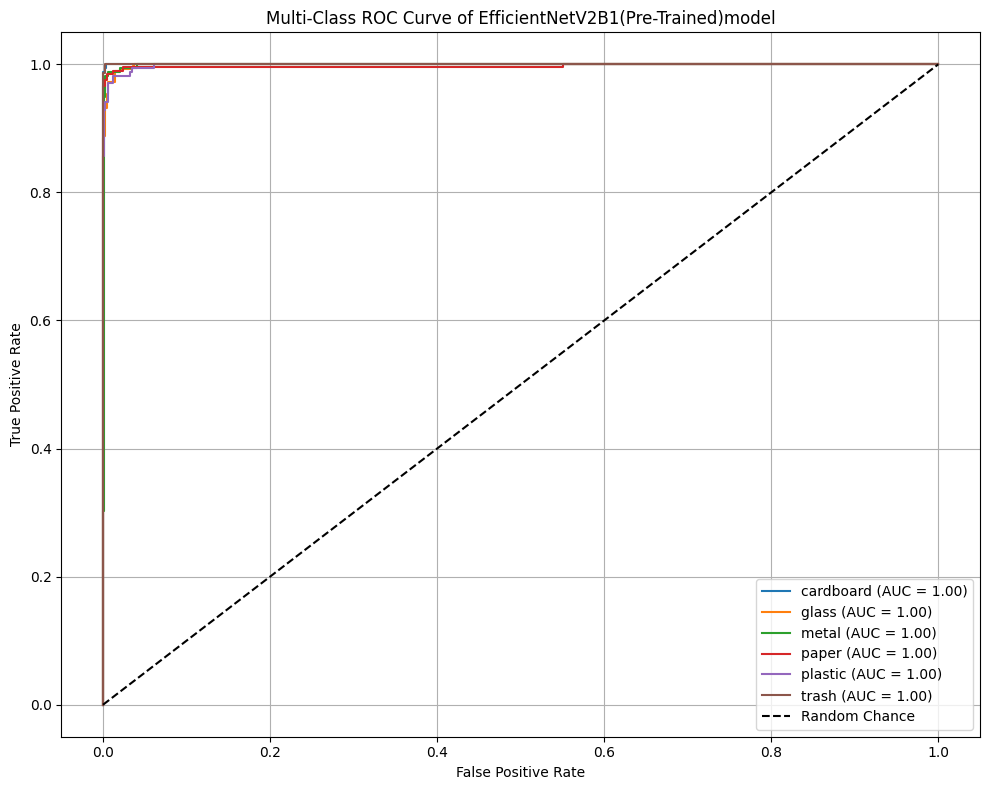

Performance Matrix
Accuracy: 97.85%
Precision: 97.86%
Recall: 97.85%
F1 Score: 97.85%
Mean Absolute Error: 0.0438
Root Mean Square Error (RMSE): 0.3351

Classification Report:

              precision    recall  f1-score   support

   cardboard       1.00      0.98      0.99       174
       glass       0.97      0.98      0.98       393
       metal       0.98      0.97      0.97       159
       paper       0.98      0.99      0.98       206
     plastic       0.96      0.96      0.96       168
       trash       0.99      0.99      0.99       156

    accuracy                           0.98      1256
   macro avg       0.98      0.98      0.98      1256
weighted avg       0.98      0.98      0.98      1256



In [27]:
# ======================== Dataset Preparation ========================
target_size = (224, 224)
batch_size = 64
validation_split = 0.2

train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="training",
    seed=50,
    image_size=target_size,
    batch_size=batch_size,
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="validation",
    seed=100,
    image_size=target_size,
    batch_size=batch_size,
)

class_names = train.class_names
print("Class Names:", class_names)

print("Building and Training the Model . . .")

# ======================== Build and Compile the Pre-trained Model ========================
base_model = tf.keras.applications.EfficientNetV2B1(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
base_model.trainable = False

ENV2B1 = models.Sequential([
    base_model,
    layers.Dense(len(class_names), activation='softmax')
])

ENV2B1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("best_ENV2B1_model.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True)

hist_efficientnetv2 = ENV2B1.fit(train, epochs=30, validation_data=validation, callbacks=[checkpoint, early_stopping])

print("Summarize the Model")

ENV2B1.summary()

print("Save training history")

hist_efficientnetv2_df = pd.DataFrame(hist_efficientnetv2.history)
print("Training History:")
print(hist_efficientnetv2_df)

print("Evaluate the Model")

X_val, y_val, y_pred = [], [], []
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())

predictions = ENV2B1.predict(np.array(X_val))
y_pred = [np.argmax(i) for i in predictions]

results_df = pd.DataFrame({'Actual': y_val, 'Prediction': y_pred})
print("Predictions vs Actual Labels:")
print(results_df)

print("Confusion Matrix")

CM = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(CM, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix of EfficientNetV2B1(Pre-Trained)model')
plt.savefig('confusion_matrix_EfficientNetV2B1.png', dpi=300)

print("ROC Curve")

# Binarize the true labels for multi-class ROC
y_val_bin = label_binarize(y_val, classes=list(range(len(class_names))))

# Get predicted probabilities for each class
y_pred_probs = predictions  # already contains softmax outputs for each class

# Compute ROC curve and AUC for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_pred_probs[:, i])
    auc = roc_auc_score(y_val_bin[:, i], y_pred_probs[:, i])
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.title('Multi-Class ROC Curve of EfficientNetV2B1(Pre-Trained)model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('multi_class_roc_curve_EfficientNetV2B1.png', dpi=300)
plt.show()

print("Performance Matrix")

# ======================== Metrics Calculation ========================
# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

# Generate and display a classification report
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, target_names=class_names))

# **MobileNetV2**

Found 6283 files belonging to 6 classes.
Using 5027 files for training.
Found 6283 files belonging to 6 classes.
Using 1256 files for validation.
Class Names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Building and Training the Model . . .
Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 189ms/step - accuracy: 0.3861 - loss: 1.6343 - val_accuracy: 0.5844 - val_loss: 1.1498
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.6219 - loss: 1.0901 - val_accuracy: 0.6361 - val_loss: 0.9930
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - accuracy: 0.6575 - loss: 0.9656 - val_accuracy: 0.6632 - val_loss: 0.9089
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - accuracy: 0.6839 - loss: 0.8853 - val_accuracy: 0.6799 - val_loss: 0.8663
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.6952 - loss: 0.8294 - val_accuracy: 0.6943 - val_loss: 0.8220
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.7091 - loss: 0.8056 - val_accuracy:

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,281,044 (8.70 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 15,374 (60.06 KB)

Save training history
Training History:
    accuracy      loss  val_accuracy  val_loss
0   0.468868  1.430367      0.584395  1.149809
1   0.631192  1.060531      0.636146  0.993027
2   0.660434  0.952764      0.663217  0.908853
3   0.689477  0.878339      0.679936  0.866260
4   0.700418  0.835955      0.694268  0.822031
5   0.714144  0.805207      0.707803  0.795108
6   0.722101  0.773843      0.713376  0.770010
7   0.732644  0.751210      0.725318  0.750215
8   0.740601  0.730003      0.730892  0.736133
9   0.747165  0.711950      0.742834  0.714944
10  0.754128  0.695168      0.746019  0.702099
11  0.760294  0.683388      0.743631  0.692121
12  0.763278  0.670379      0.753981  0.675938
13  0.771036  0.654593      0.754777  0.670517
14  0.777004  0.645229      0.761146  0.655535
15  0.773225  0.632209      0.771497  0.640236
16  0.781977  0.622445      0.770701  0.629948
17  0.785956  0.613709      0.778662  0.627231
18  0.792123  0.602671      0.773089  0.624070
19  0.791924  0.5952

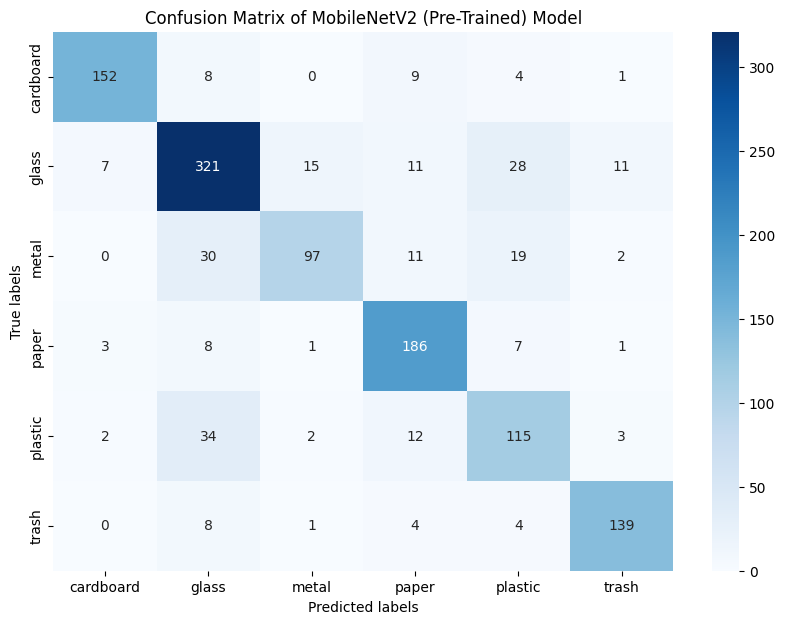

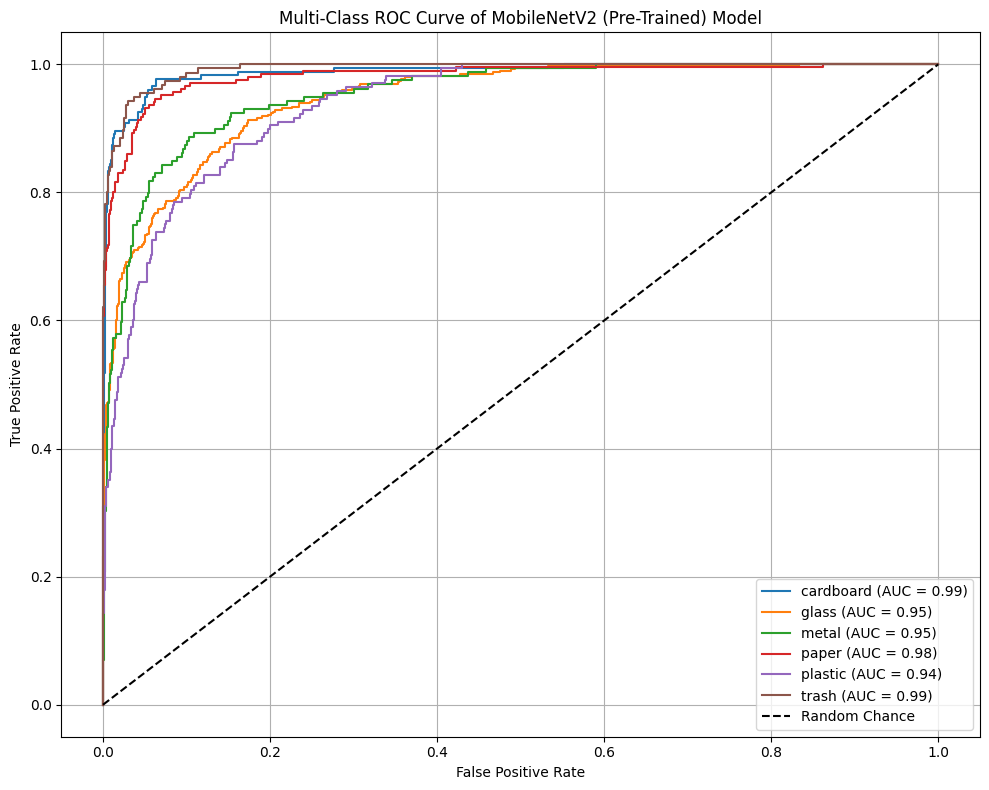

Performance Matrix
Accuracy: 80.41%
Precision: 80.76%
Recall: 80.41%
F1 Score: 80.28%
Mean Absolute Error: 0.4172
Root Mean Square Error (RMSE): 1.0543

Classification Report:

              precision    recall  f1-score   support

   cardboard       0.93      0.87      0.90       174
       glass       0.78      0.82      0.80       393
       metal       0.84      0.61      0.71       159
       paper       0.80      0.90      0.85       206
     plastic       0.65      0.68      0.67       168
       trash       0.89      0.89      0.89       156

    accuracy                           0.80      1256
   macro avg       0.81      0.80      0.80      1256
weighted avg       0.81      0.80      0.80      1256



In [28]:
# ======================== Dataset Preparation ========================
target_size = (224, 224)
batch_size = 64
validation_split = 0.2

train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="training",
    seed=50,
    image_size=target_size,
    batch_size=batch_size,
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="validation",
    seed=100,
    image_size=target_size,
    batch_size=batch_size,
)

class_names = train.class_names
print("Class Names:", class_names)

print("Building and Training the Model . . .")

# ======================== Build and Compile the Pre-trained Model ========================
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
base_model.trainable = False

MNV2 = models.Sequential([
    base_model,
    layers.Dense(len(class_names), activation='softmax')
])

MNV2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("best_MobileNetV2_model.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True)

hist_mobilenet = MNV2.fit(train, epochs=30, validation_data=validation, callbacks=[checkpoint, early_stopping])

print("Summarize the Model")

MNV2.summary()

print("Save training history")

hist_mobilenet_df = pd.DataFrame(hist_mobilenet.history)
print("Training History:")
print(hist_mobilenet_df)

print("Evaluate the Model")

X_val, y_val, y_pred = [], [], []
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())

predictions = MNV2.predict(np.array(X_val))
y_pred = [np.argmax(i) for i in predictions]

results_df = pd.DataFrame({'Actual': y_val, 'Prediction': y_pred})
print("Predictions vs Actual Labels:")
print(results_df)

print("Confusion Matrix")

CM = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(CM, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix of MobileNetV2 (Pre-Trained) Model')
plt.savefig('confusion_matrix_MobileNetV2.png', dpi=300)

print("ROC Curve")

# Binarize the true labels for multi-class ROC
y_val_bin = label_binarize(y_val, classes=list(range(len(class_names))))

# Get predicted probabilities for each class
y_pred_probs = predictions  # already contains softmax outputs for each class

# Compute ROC curve and AUC for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_pred_probs[:, i])
    auc = roc_auc_score(y_val_bin[:, i], y_pred_probs[:, i])
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.title('Multi-Class ROC Curve of MobileNetV2 (Pre-Trained) Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('multi_class_roc_curve_MobileNetV2.png', dpi=300)
plt.show()

print("Performance Matrix")

# ======================== Metrics Calculation ========================
# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

# Generate and display a classification report
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, target_names=class_names))

# **VGG19**

Found 6283 files belonging to 6 classes.
Using 5027 files for training.
Found 6283 files belonging to 6 classes.
Using 1256 files for validation.
Class Names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Building and Training the Model . . .
Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 44s 529ms/step - accuracy: 0.3449 - loss: 4.4719 - val_accuracy: 0.5844 - val_loss: 1.8935
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 38s 477ms/step - accuracy: 0.6411 - loss: 1.5639 - val_accuracy: 0.6783 - val_loss: 1.1665
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 38s 485ms/step - accuracy: 0.7279 - loss: 1.0184 - val_accuracy: 0.7341 - val_loss: 0.8827
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 39s 486ms/step - accuracy: 0.7719 - loss: 0.8085 - val_accuracy: 0.7826 - val_loss: 0.6946
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 38s 483ms/step - accuracy: 0.8037 - loss: 0.6548 - val_accuracy: 0.8065 - val_loss: 0.6119
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 38s 485ms/step - accuracy: 0.8257 - loss: 0.5897 - val_accu

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 512)            │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,033,620 (76.42 MB)

 Trainable params: 3,078 (12.02 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

 Optimizer params: 6,158 (24.06 KB)

Save training history
Training History:
    accuracy      loss  val_accuracy  val_loss
0   0.436841  3.299194      0.584395  1.893467
1   0.657251  1.418570      0.678344  1.166514
2   0.729660  0.984226      0.734076  0.882743
3   0.773225  0.771910      0.782643  0.694644
4   0.803859  0.646351      0.806529  0.611921
5   0.825542  0.564492      0.837580  0.533901
6   0.841655  0.497835      0.846338  0.480393
7   0.854386  0.449203      0.853503  0.440500
8   0.866521  0.407656      0.861465  0.407209
9   0.870897  0.377765      0.869427  0.382071
10  0.878257  0.348682      0.878185  0.350993
11  0.888801  0.324335      0.887739  0.328486
12  0.894370  0.307923      0.890127  0.323960
13  0.898946  0.287995      0.897293  0.295245
14  0.903322  0.272004      0.899682  0.287840
15  0.907102  0.261532      0.899682  0.280055
16  0.915059  0.245926      0.906051  0.265950
17  0.915258  0.235334      0.910032  0.257292
18  0.919435  0.230094      0.912420  0.249857
19  0.926994  0.2167

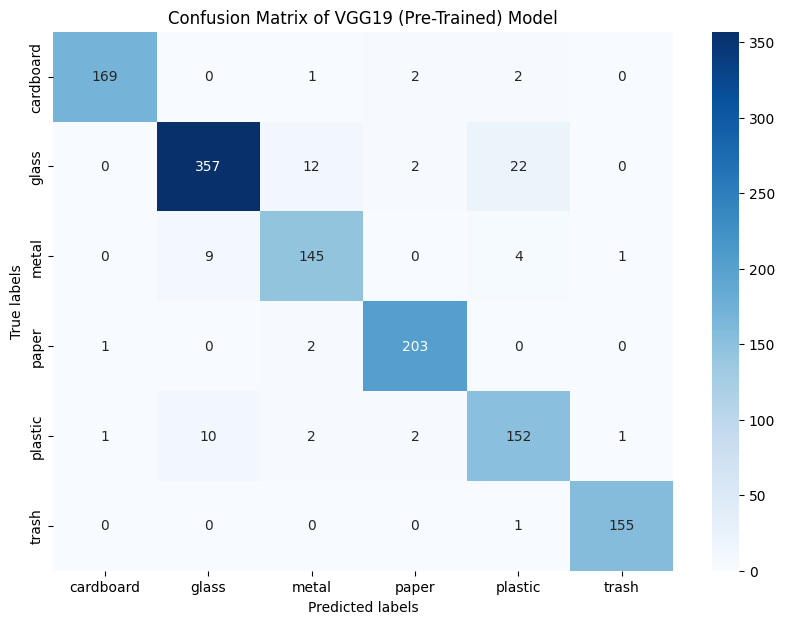

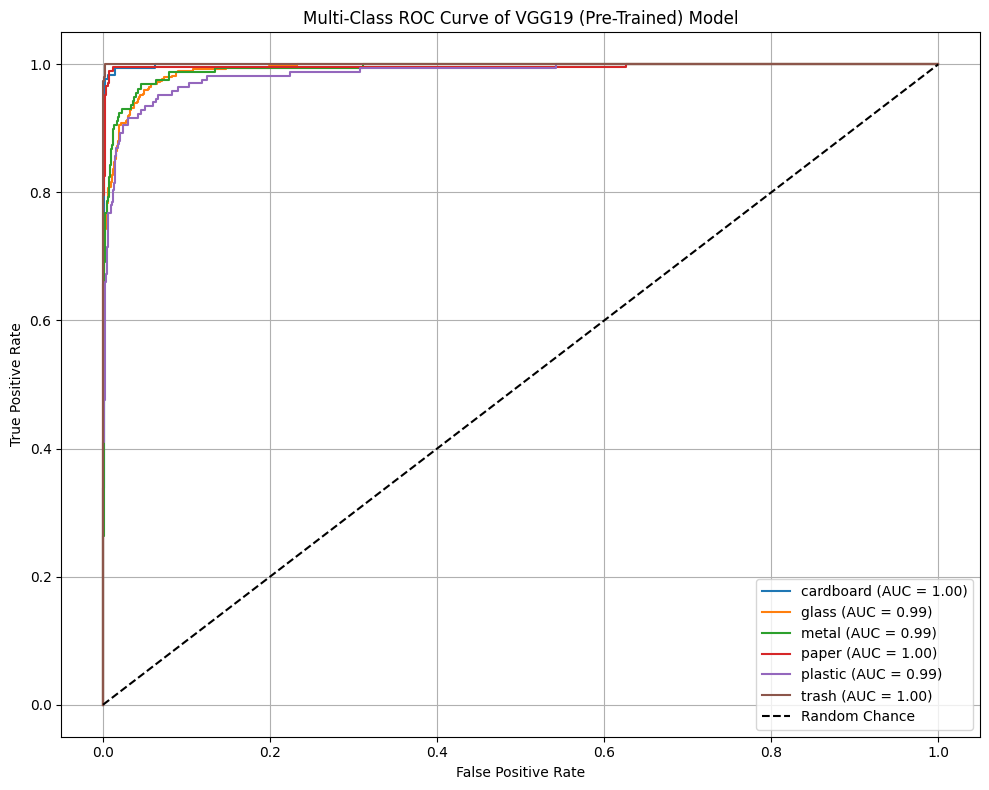

Performance Matrix
Accuracy: 94.03%
Precision: 94.16%
Recall: 94.03%
F1 Score: 94.06%
Mean Absolute Error: 0.1314
Root Mean Square Error (RMSE): 0.5885

Classification Report:

              precision    recall  f1-score   support

   cardboard       0.99      0.97      0.98       174
       glass       0.95      0.91      0.93       393
       metal       0.90      0.91      0.90       159
       paper       0.97      0.99      0.98       206
     plastic       0.84      0.90      0.87       168
       trash       0.99      0.99      0.99       156

    accuracy                           0.94      1256
   macro avg       0.94      0.95      0.94      1256
weighted avg       0.94      0.94      0.94      1256



In [29]:
# ======================== Dataset Preparation ========================
target_size = (224, 224)
batch_size = 64
validation_split = 0.2

train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="training",
    seed=50,
    image_size=target_size,
    batch_size=batch_size,
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="validation",
    seed=100,
    image_size=target_size,
    batch_size=batch_size,
)

class_names = train.class_names
print("Class Names:", class_names)

print("Building and Training the Model . . .")

# ======================== Build and Compile the Pre-trained Model ========================
base_model = tf.keras.applications.VGG19(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
base_model.trainable = False

v19 = models.Sequential([
    base_model,
    layers.Dense(len(class_names), activation='softmax')
])

v19.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("best_VGG19_model.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True)

hist_vgg19 = v19.fit(train, epochs=30, validation_data=validation, callbacks=[checkpoint, early_stopping])

print("Summarize the Model")

v19.summary()

print("Save training history")

hist_vgg19_df = pd.DataFrame(hist_vgg19.history)
print("Training History:")
print(hist_vgg19_df)

print("Evaluate the Model")

X_val, y_val, y_pred = [], [], []
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())

predictions = v19.predict(np.array(X_val))
y_pred = [np.argmax(i) for i in predictions]

results_df = pd.DataFrame({'Actual': y_val, 'Prediction': y_pred})
print("Predictions vs Actual Labels:")
print(results_df)

print("Confusion Matrix")

CM = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(CM, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix of VGG19 (Pre-Trained) Model')
plt.savefig('confusion_matrix_VGG19.png', dpi=300)

print("ROC Curve")

# Binarize the true labels for multi-class ROC
y_val_bin = label_binarize(y_val, classes=list(range(len(class_names))))

# Get predicted probabilities for each class
y_pred_probs = predictions  # already contains softmax outputs for each class

# Compute ROC curve and AUC for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_pred_probs[:, i])
    auc = roc_auc_score(y_val_bin[:, i], y_pred_probs[:, i])
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.title('Multi-Class ROC Curve of VGG19 (Pre-Trained) Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('multi_class_roc_curve_VGG19.png', dpi=300)
plt.show()

print("Performance Matrix")

# ======================== Metrics Calculation ========================
# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

# Generate and display a classification report
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, target_names=class_names))

# **ResNet50**

Found 6283 files belonging to 6 classes.
Using 5027 files for training.
Found 6283 files belonging to 6 classes.
Using 1256 files for validation.
Class Names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Building and Training the Model . . .
Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 34s 314ms/step - accuracy: 0.5205 - loss: 1.2946 - val_accuracy: 0.8280 - val_loss: 0.5166
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 224ms/step - accuracy: 0.8379 - loss: 0.4636 - val_accuracy: 0.8814 - val_loss: 0.3712
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 220ms/step - accuracy: 0.8871 - loss: 0.3424 - val_accuracy: 0.9061 - val_loss: 0.3094
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 213ms/step - accuracy: 0.9090 - loss: 0.2891 - val_accuracy: 0.9156 - val_loss: 0.2750
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 213ms/step - accuracy: 0.9217 - loss: 0.2497 - val_accuracy: 0.9275 - val_loss: 0.2453
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 217ms/step - accuracy: 0.9302 - loss: 0.2259 - val_accu

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 6)              │        12,294 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,624,596 (90.12 MB)

 Trainable params: 12,294 (48.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 24,590 (96.06 KB)

Save training history
Training History:
    accuracy      loss  val_accuracy  val_loss
0   0.661826  0.935282      0.828025  0.516564
1   0.849214  0.443534      0.881369  0.371213
2   0.889795  0.342667      0.906051  0.309396
3   0.907499  0.286955      0.915605  0.275034
4   0.919236  0.253508      0.927548  0.245280
5   0.928984  0.226371      0.929140  0.227433
6   0.936941  0.203887      0.936306  0.208725
7   0.945295  0.187012      0.942675  0.195072
8   0.949075  0.171587      0.941879  0.182586
9   0.954645  0.159125      0.949045  0.171537
10  0.959021  0.148127      0.953822  0.163406
11  0.961408  0.138132      0.952229  0.156252
12  0.966978  0.130140      0.960987  0.149594
13  0.970161  0.121081      0.962580  0.141994
14  0.971753  0.115485      0.966560  0.138554
15  0.974339  0.108198      0.964172  0.133622
16  0.978516  0.102140      0.966560  0.127099
17  0.980505  0.096076      0.967357  0.123665
18  0.979511  0.091804      0.968153  0.119667
19  0.982693  0.0868

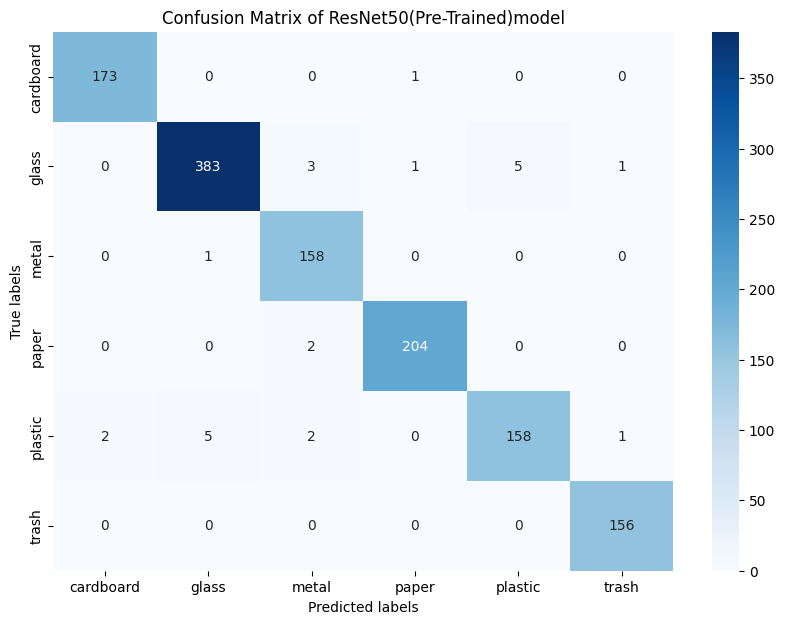

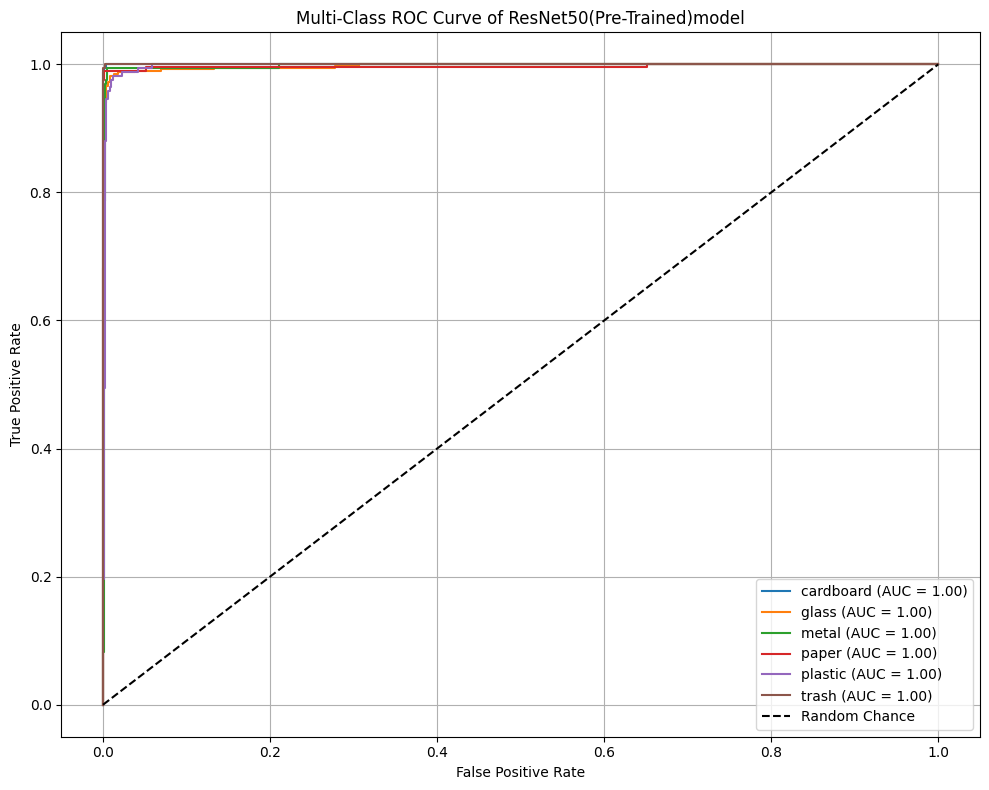

Performance Matrix
Accuracy: 98.09%
Precision: 98.10%
Recall: 98.09%
F1 Score: 98.08%
Mean Absolute Error: 0.0462
Root Mean Square Error (RMSE): 0.3635

Classification Report:

              precision    recall  f1-score   support

   cardboard       0.99      0.99      0.99       174
       glass       0.98      0.97      0.98       393
       metal       0.96      0.99      0.98       159
       paper       0.99      0.99      0.99       206
     plastic       0.97      0.94      0.95       168
       trash       0.99      1.00      0.99       156

    accuracy                           0.98      1256
   macro avg       0.98      0.98      0.98      1256
weighted avg       0.98      0.98      0.98      1256



In [30]:
# ======================== Dataset Preparation ========================
target_size = (224, 224)
batch_size = 64
validation_split = 0.2

train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="training",
    seed=50,
    image_size=target_size,
    batch_size=batch_size,
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="validation",
    seed=100,
    image_size=target_size,
    batch_size=batch_size,
)

class_names = train.class_names
print("Class Names:", class_names)

print("Building and Training the Model . . .")

# ======================== Build and Compile the Pre-trained Model ========================
base_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
base_model.trainable = False

RN50 = models.Sequential([
    base_model,
    layers.Dense(len(class_names), activation='softmax')
])

RN50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("best_RN50_model.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True)

hist_resnet = RN50.fit(train, epochs=30, validation_data=validation, callbacks=[checkpoint, early_stopping])

print("Summarize the Model")

RN50.summary()

print("Save training history")

hist_resnet_df = pd.DataFrame(hist_resnet.history)
print("Training History:")
print(hist_resnet_df)

print("Evaluate the Model")

X_val, y_val, y_pred = [], [], []
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())

predictions = RN50.predict(np.array(X_val))
y_pred = [np.argmax(i) for i in predictions]

results_df = pd.DataFrame({'Actual': y_val, 'Prediction': y_pred})
print("Predictions vs Actual Labels:")
print(results_df)

print("Confusion Matrix")

CM = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(CM, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix of ResNet50(Pre-Trained)model')
plt.savefig('confusion_matrix_ResNet50.png', dpi=300)

print("ROC Curve")

# Binarize the true labels for multi-class ROC
y_val_bin = label_binarize(y_val, classes=list(range(len(class_names))))

# Get predicted probabilities for each class
y_pred_probs = predictions  # already contains softmax outputs for each class

# Compute ROC curve and AUC for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_pred_probs[:, i])
    auc = roc_auc_score(y_val_bin[:, i], y_pred_probs[:, i])
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.title('Multi-Class ROC Curve of ResNet50(Pre-Trained)model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('multi_class_roc_curve_ResNet50.png', dpi=300)
plt.show()

print("Performance Matrix")

# ======================== Metrics Calculation ========================
# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

# Generate and display a classification report
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, target_names=class_names))

# **EfficientNetB0**

Found 6283 files belonging to 6 classes.
Using 5027 files for training.
Found 6283 files belonging to 6 classes.
Using 1256 files for validation.
Class Names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Building and Training the Model . . .
Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 42s 318ms/step - accuracy: 0.4717 - loss: 1.4242 - val_accuracy: 0.8320 - val_loss: 0.6062
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.8369 - loss: 0.5532 - val_accuracy: 0.8909 - val_loss: 0.4034
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.8888 - loss: 0.3945 - val_accuracy: 0.9084 - val_loss: 0.3231
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - accuracy: 0.9070 - loss: 0.3258 - val_accuracy: 0.9180 - val_loss: 0.2782
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.9263 - loss: 0.2741 - val_accuracy: 0.9244 - val_loss: 0.2477
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 0.9271 - loss: 0.2533 - val_accuracy:

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,072,631 (15.54 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 15,374 (60.06 KB)

Save training history
Training History:
    accuracy      loss  val_accuracy  val_loss
0   0.645514  1.075099      0.832006  0.606238
1   0.851402  0.511179      0.890924  0.403410
2   0.892182  0.380734      0.908440  0.323053
3   0.910284  0.314560      0.917994  0.278200
4   0.921424  0.273023      0.924363  0.247725
5   0.929779  0.248758      0.929140  0.225953
6   0.935548  0.228692      0.938694  0.209209
7   0.939328  0.212539      0.944268  0.195144
8   0.942510  0.197050      0.947452  0.184192
9   0.948677  0.186233      0.950637  0.175002
10  0.951661  0.171471      0.950637  0.165536
11  0.953650  0.166430      0.953822  0.157877
12  0.955441  0.157082      0.956210  0.151004
13  0.954048  0.151696      0.960987  0.144426
14  0.959817  0.144469      0.962580  0.138708
15  0.961806  0.137130      0.964172  0.134626
16  0.963199  0.135514      0.963376  0.130711
17  0.965188  0.127565      0.966560  0.125660
18  0.967774  0.120870      0.973726  0.121418
19  0.967973  0.1191

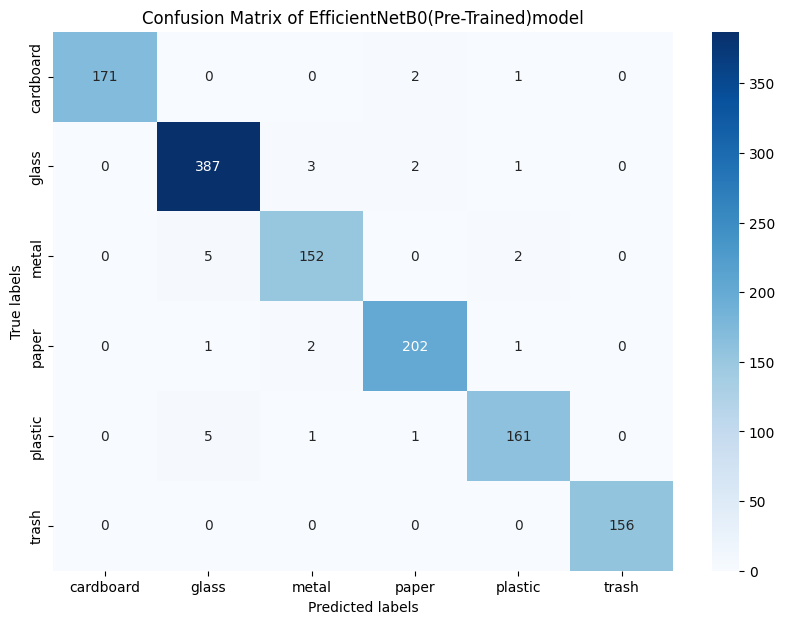

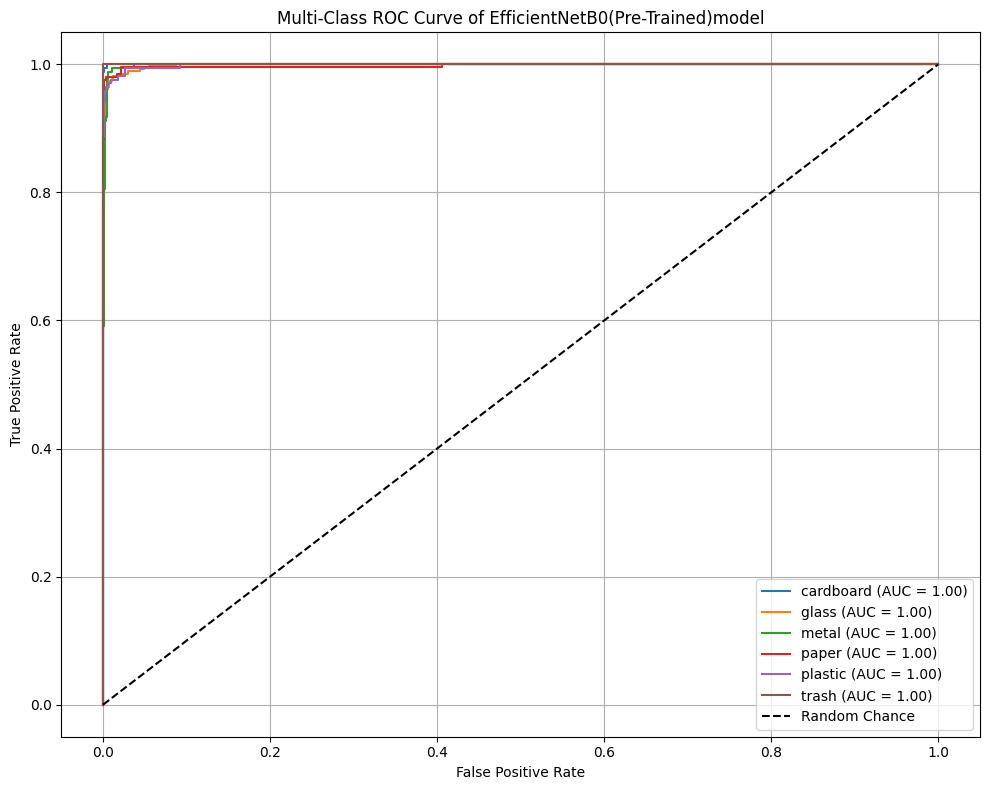

Performance Matrix
Accuracy: 97.85%
Precision: 97.86%
Recall: 97.85%
F1 Score: 97.85%
Mean Absolute Error: 0.0414
Root Mean Square Error (RMSE): 0.3142

Classification Report:

              precision    recall  f1-score   support

   cardboard       1.00      0.98      0.99       174
       glass       0.97      0.98      0.98       393
       metal       0.96      0.96      0.96       159
       paper       0.98      0.98      0.98       206
     plastic       0.97      0.96      0.96       168
       trash       1.00      1.00      1.00       156

    accuracy                           0.98      1256
   macro avg       0.98      0.98      0.98      1256
weighted avg       0.98      0.98      0.98      1256



In [31]:
# ======================== Dataset Preparation ========================
target_size = (224, 224)
batch_size = 64
validation_split = 0.2

train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="training",
    seed=50,
    image_size=target_size,
    batch_size=batch_size,
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="validation",
    seed=100,
    image_size=target_size,
    batch_size=batch_size,
)

class_names = train.class_names
print("Class Names:", class_names)

print("Building and Training the Model . . .")

# ======================== Build and Compile the Pre-trained Model ========================
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
base_model.trainable = False

ENB0 = models.Sequential([
    base_model,
    layers.Dense(len(class_names), activation='softmax')
])

ENB0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("best_ENB0_model.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True)

hist_efficientnet = ENB0.fit(train, epochs=30, validation_data=validation, callbacks=[checkpoint, early_stopping])

print("Summarize the Model")

ENB0.summary()

print("Save training history")

hist_efficientnet_df = pd.DataFrame(hist_efficientnet.history)
print("Training History:")
print(hist_efficientnet_df)

print("Evaluate the Model")

X_val, y_val, y_pred = [], [], []
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())

predictions = ENB0.predict(np.array(X_val))
y_pred = [np.argmax(i) for i in predictions]

results_df = pd.DataFrame({'Actual': y_val, 'Prediction': y_pred})
print("Predictions vs Actual Labels:")
print(results_df)

print("Confusion Matrix")

CM = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(CM, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix of EfficientNetB0(Pre-Trained)model')
plt.savefig('confusion_matrix_EfficientNetB0.png', dpi=300)

print("ROC Curve")

# Binarize the true labels for multi-class ROC
y_val_bin = label_binarize(y_val, classes=list(range(len(class_names))))

# Get predicted probabilities for each class
y_pred_probs = predictions  # already contains softmax outputs for each class

# Compute ROC curve and AUC for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_pred_probs[:, i])
    auc = roc_auc_score(y_val_bin[:, i], y_pred_probs[:, i])
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.title('Multi-Class ROC Curve of EfficientNetB0(Pre-Trained)model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('multi_class_roc_curve_EfficientNetB0.png', dpi=300)
plt.show()

print("Performance Matrix")

# ======================== Metrics Calculation ========================
# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

# Generate and display a classification report
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, target_names=class_names))

# **Performance Curves**

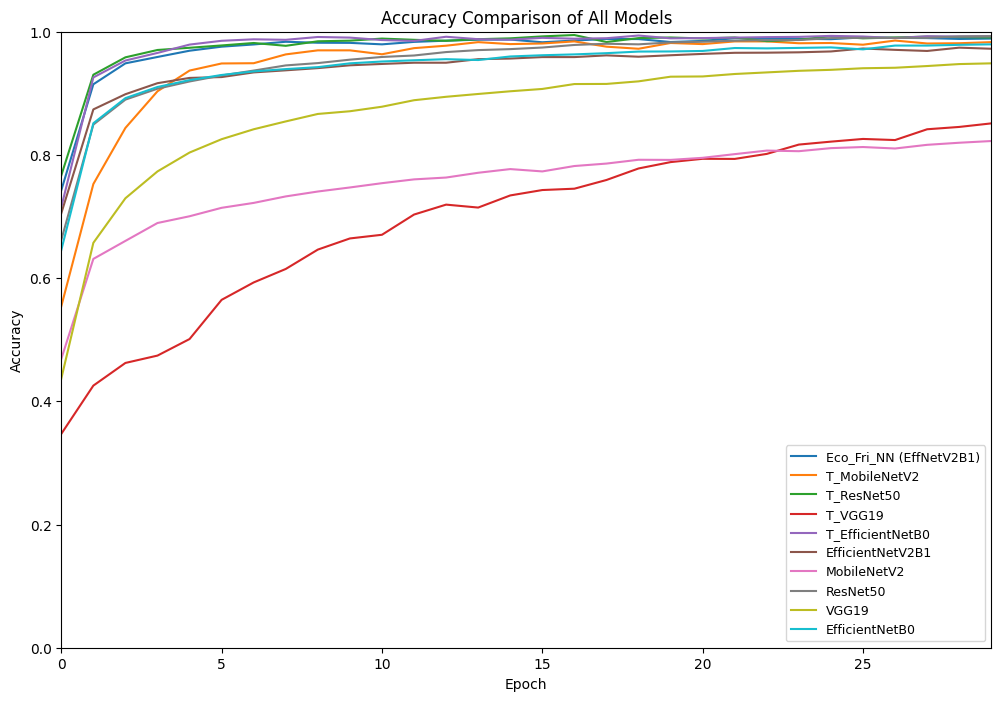

In [32]:
# Accuracy values
acc_eco_fri_nn = hist_eco_fri_nn_df['accuracy']
acc_tmobilenet = hist_tmobilenet_df['accuracy']
acc_tresnet50 = hist_tresnet_df['accuracy']
acc_tvgg19 = hist_tvgg19_df['accuracy']
acc_tefficientb0 = hist_tefficientnet_df['accuracy']
acc_efficientv2b1 = hist_efficientnetv2_df['accuracy']
acc_mobilenet = hist_mobilenet_df['accuracy']
acc_resnet50 = hist_resnet_df['accuracy']
acc_vgg19 = hist_vgg19_df['accuracy']
acc_efficientb0 = hist_efficientnet_df['accuracy']

plt.figure(figsize=(12, 8))

plt.plot(acc_eco_fri_nn, label='Eco_Fri_NN (EffNetV2B1)')
plt.plot(acc_tmobilenet, label='T_MobileNetV2')
plt.plot(acc_tresnet50, label='T_ResNet50')
plt.plot(acc_tvgg19, label='T_VGG19')
plt.plot(acc_tefficientb0, label='T_EfficientNetB0')
plt.plot(acc_efficientv2b1, label='EfficientNetV2B1')
plt.plot(acc_mobilenet, label='MobileNetV2')
plt.plot(acc_resnet50, label='ResNet50')
plt.plot(acc_vgg19, label='VGG19')
plt.plot(acc_efficientb0, label='EfficientNetB0')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of All Models')
plt.legend(loc='lower right', fontsize=9)
plt.ylim(0, 1)
plt.gca().margins(x=0)

plt.savefig('Accuracy.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

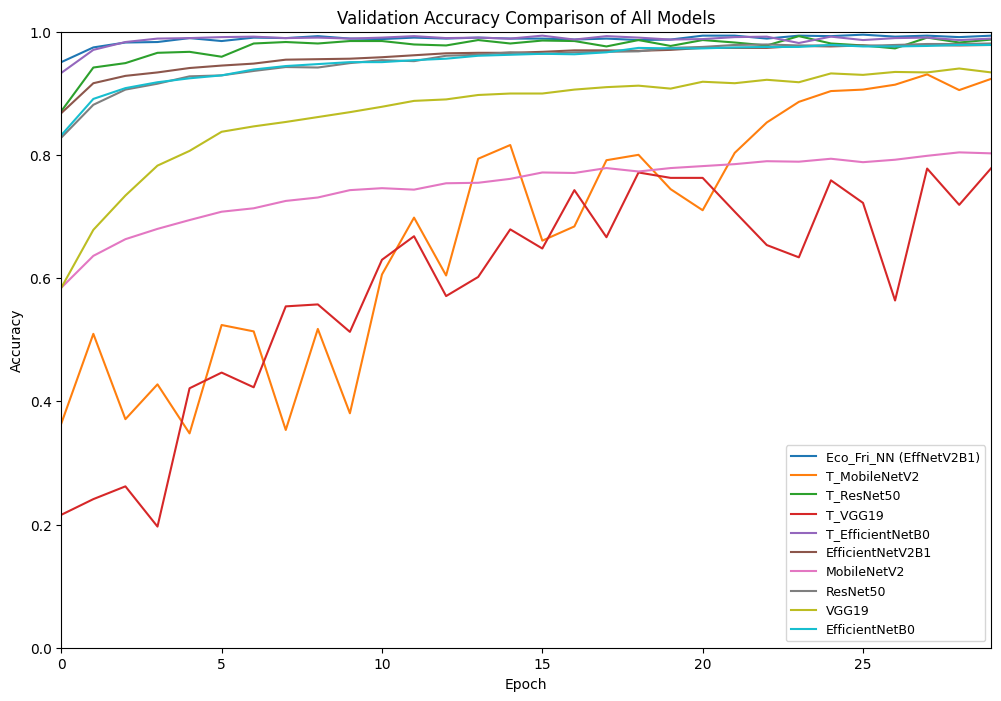

In [33]:
# Validation Accuracy values
val_acc_eco_fri_nn = hist_eco_fri_nn_df['val_accuracy']
val_acc_tmobilenet = hist_tmobilenet_df['val_accuracy']
val_acc_tresnet50 = hist_tresnet_df['val_accuracy']
val_acc_tvgg19 = hist_tvgg19_df['val_accuracy']
val_acc_tefficientb0 = hist_tefficientnet_df['val_accuracy']
val_acc_efficientv2b1 = hist_efficientnetv2_df['val_accuracy']
val_acc_mobilenet = hist_mobilenet_df['val_accuracy']
val_acc_resnet50 = hist_resnet_df['val_accuracy']
val_acc_vgg19 = hist_vgg19_df['val_accuracy']
val_acc_efficientb0 = hist_efficientnet_df['val_accuracy']

plt.figure(figsize=(12, 8))

plt.plot(val_acc_eco_fri_nn, label='Eco_Fri_NN (EffNetV2B1)')
plt.plot(val_acc_tmobilenet, label='T_MobileNetV2')
plt.plot(val_acc_tresnet50, label='T_ResNet50')
plt.plot(val_acc_tvgg19, label='T_VGG19')
plt.plot(val_acc_tefficientb0, label='T_EfficientNetB0')
plt.plot(val_acc_efficientv2b1, label='EfficientNetV2B1')
plt.plot(val_acc_mobilenet, label='MobileNetV2')
plt.plot(val_acc_resnet50, label='ResNet50')
plt.plot(val_acc_vgg19, label='VGG19')
plt.plot(val_acc_efficientb0, label='EfficientNetB0')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Comparison of All Models')
plt.legend(loc='lower right', fontsize=9)
plt.ylim(0, 1)
plt.gca().margins(x=0)

plt.savefig('Validation_Accuracy.png', format='png', dpi=600, bbox_inches='tight')
plt.show()


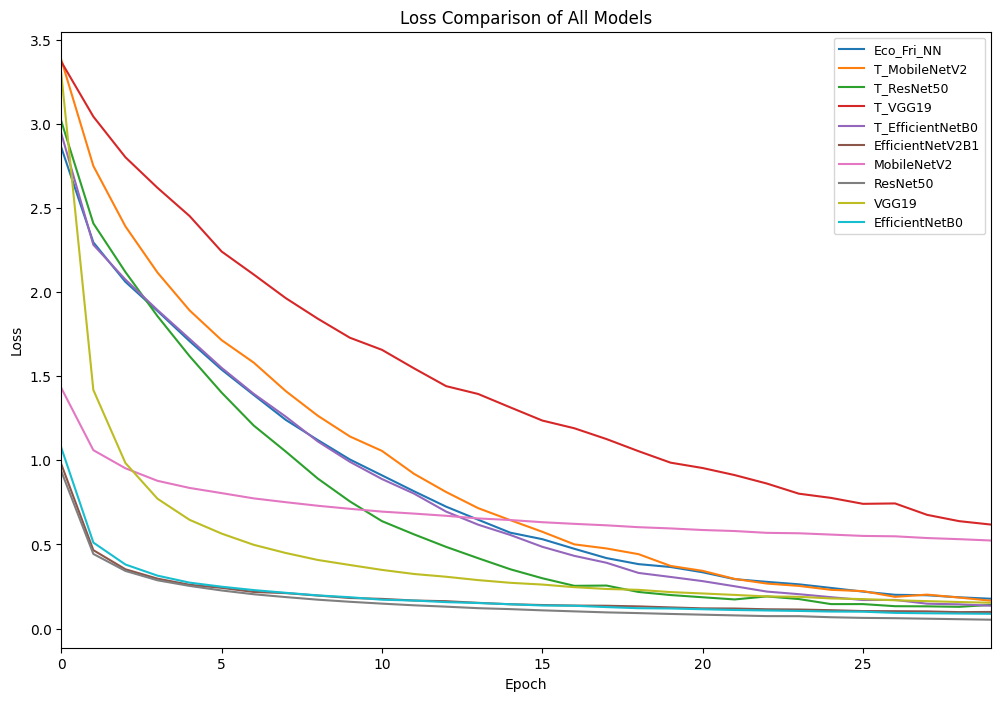

In [34]:
# Training Loss values
loss_eco_fri_nn = hist_eco_fri_nn_df['loss']
loss_tmobilenet = hist_tmobilenet_df['loss']
loss_tresnet50 = hist_tresnet_df['loss']
loss_tvgg19 = hist_tvgg19_df['loss']
loss_tefficientb0 = hist_tefficientnet_df['loss']
loss_efficientv2b1 = hist_efficientnetv2_df['loss']
loss_mobilenet = hist_mobilenet_df['loss']
loss_resnet50 = hist_resnet_df['loss']
loss_vgg19 = hist_vgg19_df['loss']
loss_efficientb0 = hist_efficientnet_df['loss']

plt.figure(figsize=(12, 8))

plt.plot(loss_eco_fri_nn, label='Eco_Fri_NN')
plt.plot(loss_tmobilenet, label='T_MobileNetV2')
plt.plot(loss_tresnet50, label='T_ResNet50')
plt.plot(loss_tvgg19, label='T_VGG19')
plt.plot(loss_tefficientb0, label='T_EfficientNetB0')
plt.plot(loss_efficientv2b1, label='EfficientNetV2B1')
plt.plot(loss_mobilenet, label='MobileNetV2')
plt.plot(loss_resnet50, label='ResNet50')
plt.plot(loss_vgg19, label='VGG19')
plt.plot(loss_efficientb0, label='EfficientNetB0')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison of All Models')
plt.legend(loc='upper right', fontsize=9)
plt.gca().margins(x=0)

plt.savefig('Loss.png', format='png', dpi=600, bbox_inches='tight')
plt.show()


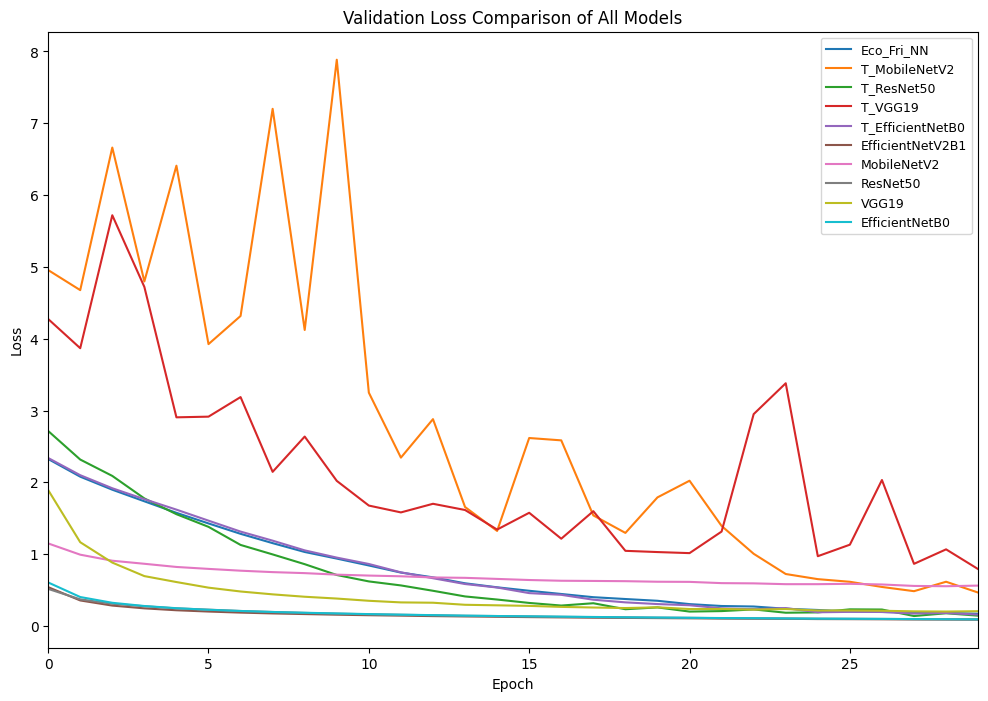

In [35]:
# Validation Loss values
val_loss_eco_fri_nn = hist_eco_fri_nn_df['val_loss']
val_loss_tmobilenet = hist_tmobilenet_df['val_loss']
val_loss_tresnet50 = hist_tresnet_df['val_loss']
val_loss_tvgg19 = hist_tvgg19_df['val_loss']
val_loss_tefficientb0 = hist_tefficientnet_df['val_loss']
val_loss_efficientv2b1 = hist_efficientnetv2_df['val_loss']
val_loss_mobilenet = hist_mobilenet_df['val_loss']
val_loss_resnet50 = hist_resnet_df['val_loss']
val_loss_vgg19 = hist_vgg19_df['val_loss']
val_loss_efficientb0 = hist_efficientnet_df['val_loss']

plt.figure(figsize=(12, 8))

plt.plot(val_loss_eco_fri_nn, label='Eco_Fri_NN')
plt.plot(val_loss_tmobilenet, label='T_MobileNetV2')
plt.plot(val_loss_tresnet50, label='T_ResNet50')
plt.plot(val_loss_tvgg19, label='T_VGG19')
plt.plot(val_loss_tefficientb0, label='T_EfficientNetB0')
plt.plot(val_loss_efficientv2b1, label='EfficientNetV2B1')
plt.plot(val_loss_mobilenet, label='MobileNetV2')
plt.plot(val_loss_resnet50, label='ResNet50')
plt.plot(val_loss_vgg19, label='VGG19')
plt.plot(val_loss_efficientb0, label='EfficientNetB0')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Comparison of All Models')
plt.legend(loc='upper right', fontsize=9)
plt.gca().margins(x=0)

plt.savefig('Validation_Loss.png', format='png', dpi=600, bbox_inches='tight')
plt.show()


# **ROC Curves**

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 225ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 230ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


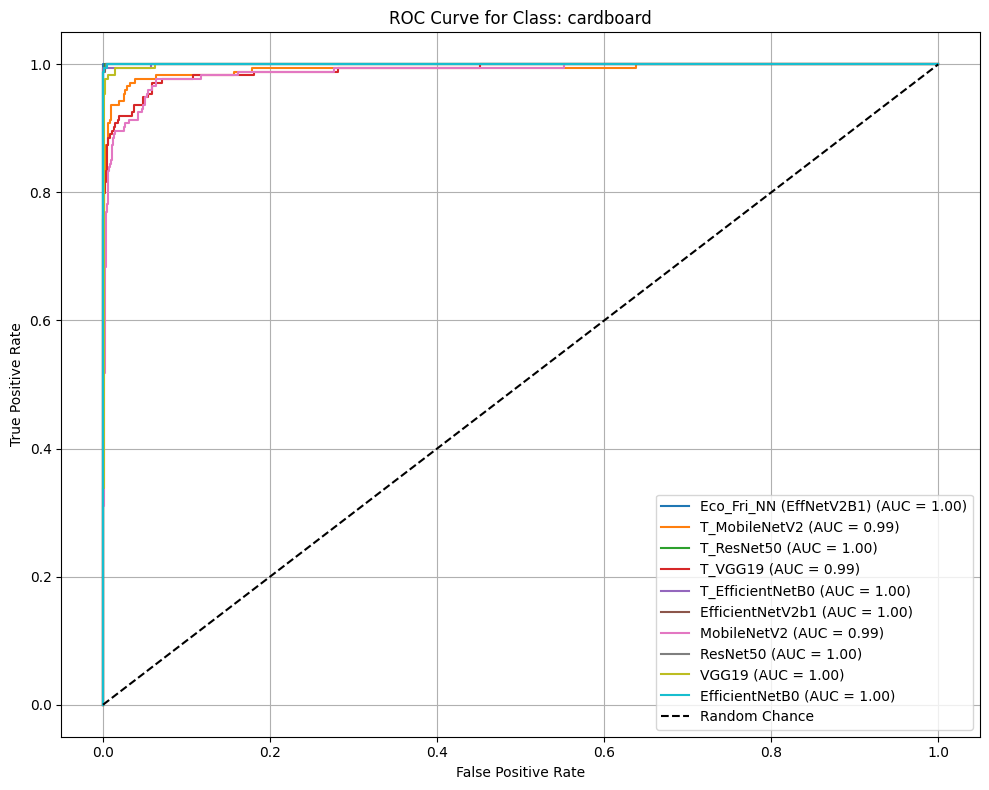

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 214ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 227ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


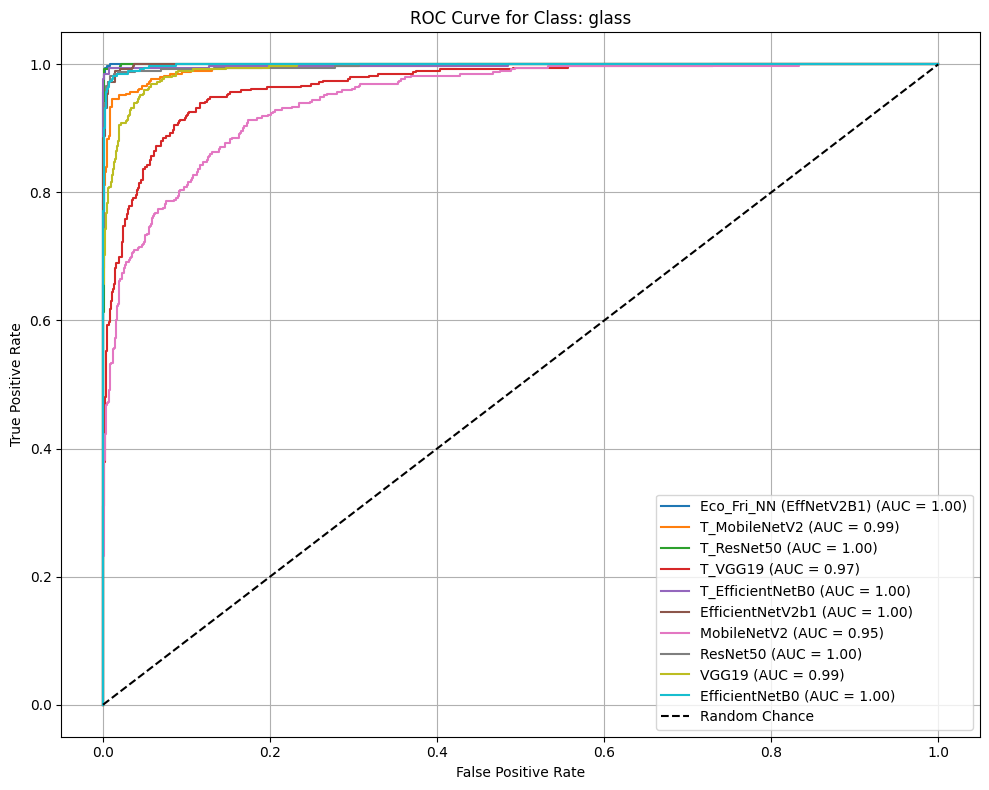

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 224ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


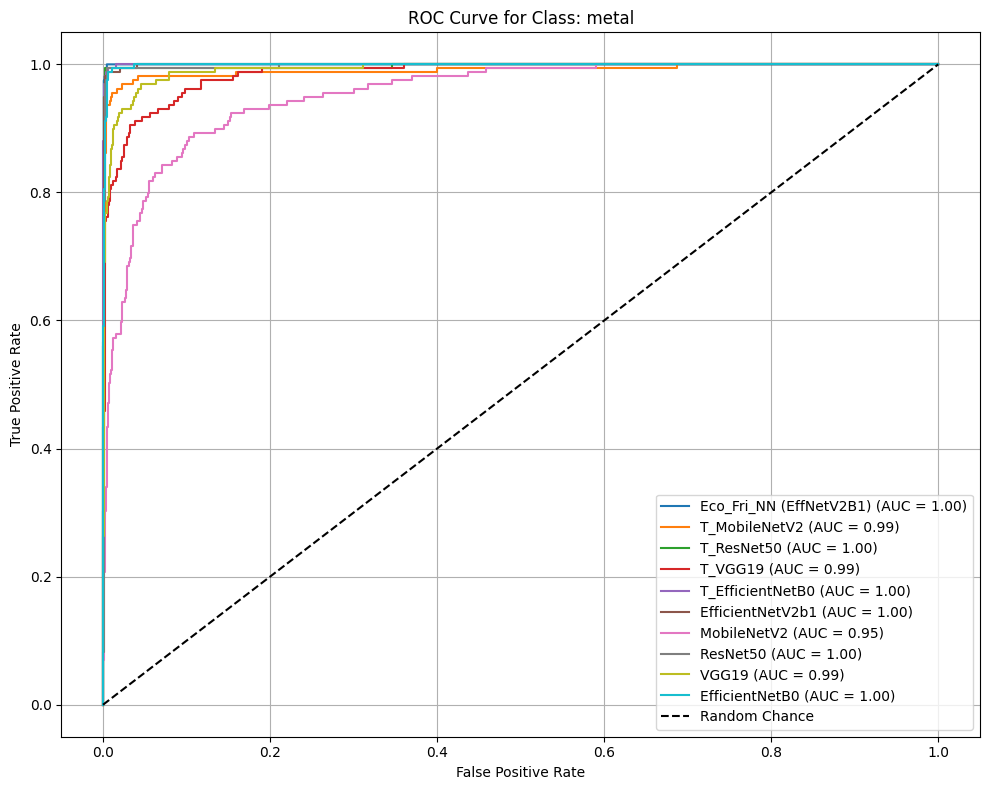

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 218ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 226ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


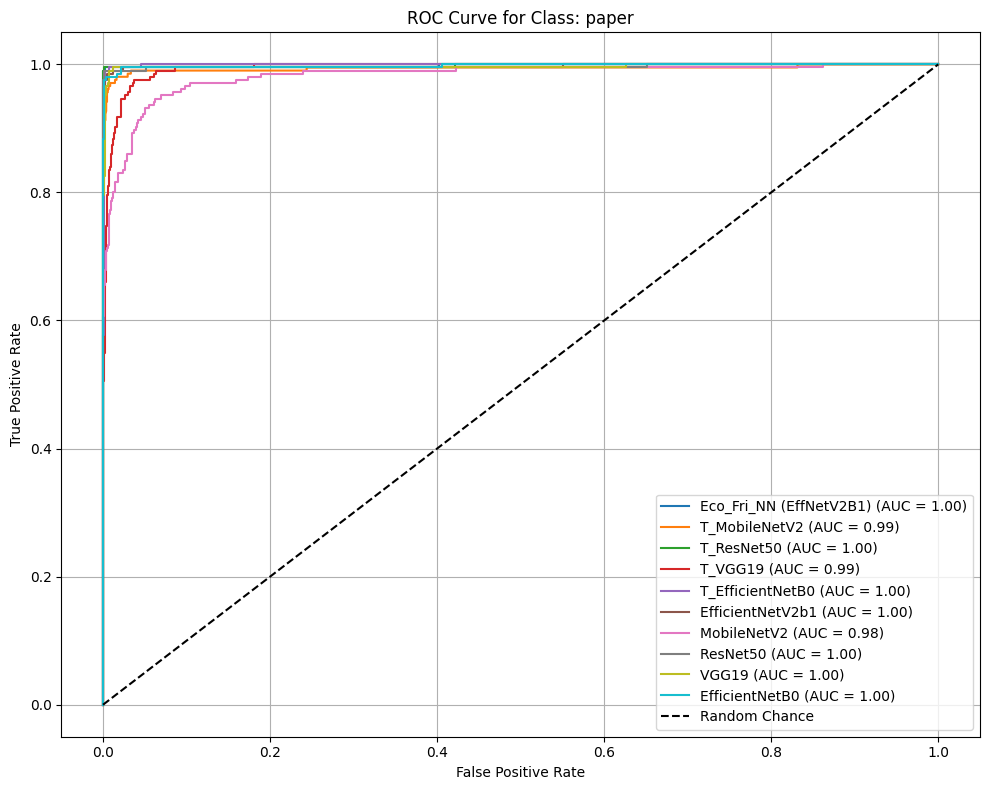

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 218ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 226ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


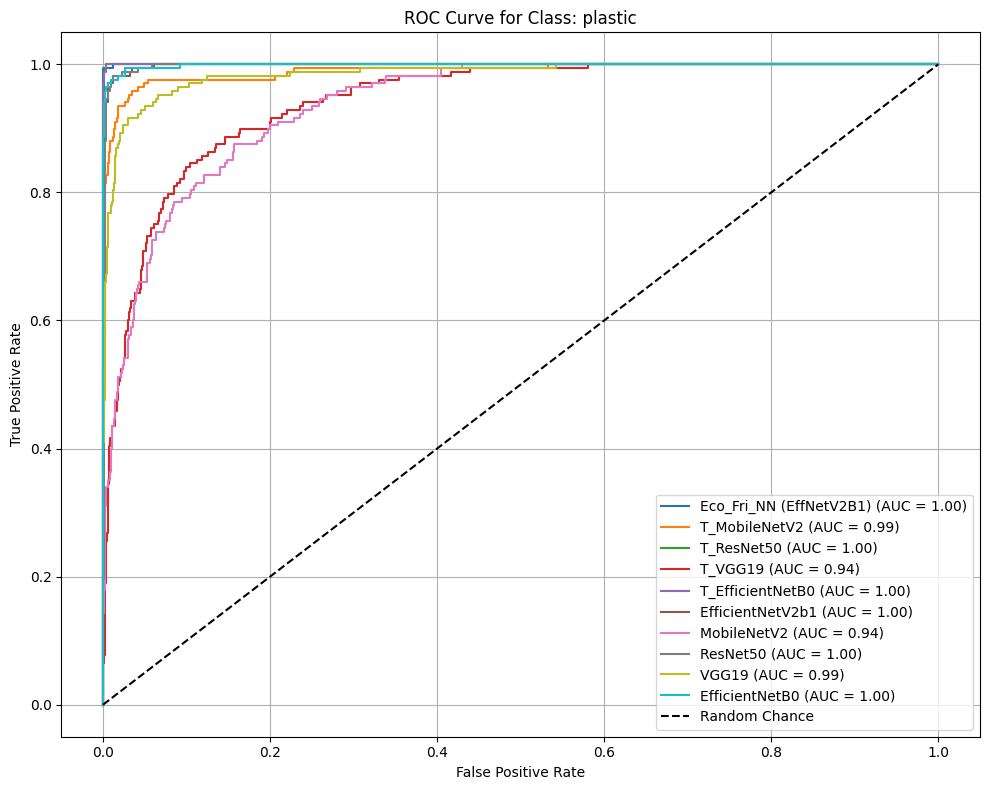

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 219ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 226ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


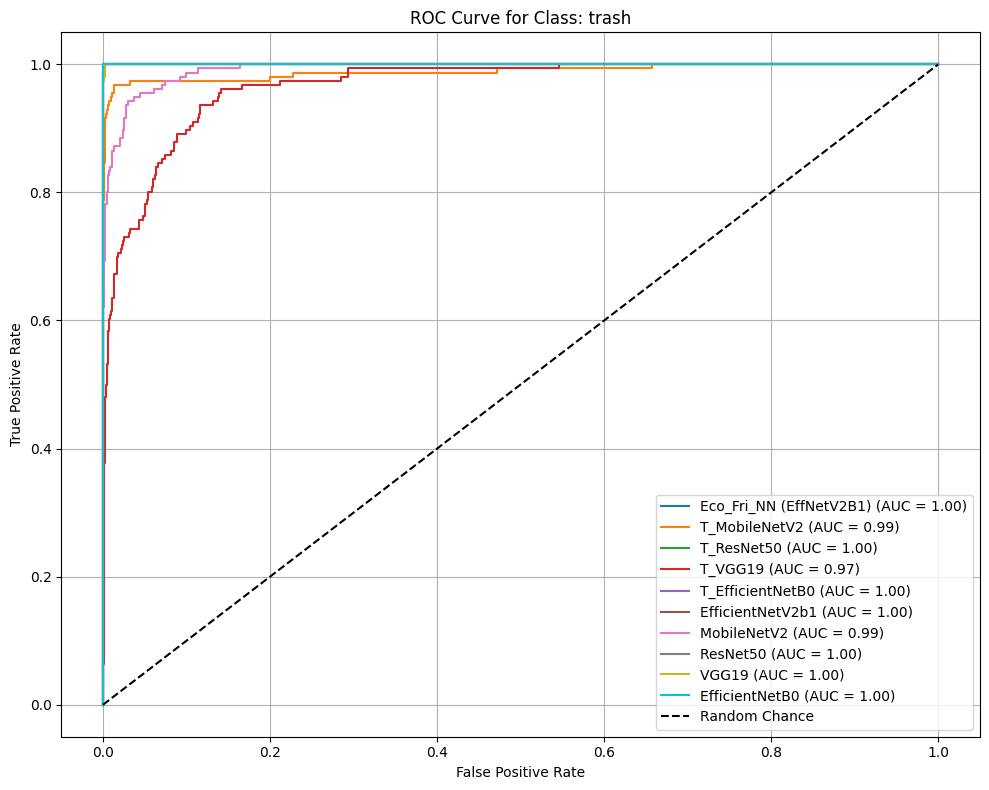

In [36]:
# Assuming predictions and y_val are already obtained from the model as you have in your existing code

# Binarize the true labels for each class individually
y_val_bin = label_binarize(y_val, classes=list(range(len(class_names))))

# List of all models for plotting
models = [eco_fri_nn, T_MobileNetV2, T_ResNet50, T_VGG19, T_EfficientNetB0, ENV2B1, MNV2, RN50, v19, ENB0]
model_names = ['Eco_Fri_NN (EffNetV2B1)', 'T_MobileNetV2', 'T_ResNet50', 'T_VGG19', 'T_EfficientNetB0',  'EfficientNetV2b1', 'MobileNetV2', 'ResNet50', 'VGG19', 'EfficientNetB0']

# Iterate over each class (6 classes) and plot ROC curves for each model
for i, class_name in enumerate(class_names):
    plt.figure(figsize=(10, 8))

    # For each model, calculate the ROC curve and AUC for the current class
    for model, model_name in zip(models, model_names):
        # Get predicted probabilities for each class (for multi-class classification)
        y_pred_probs = model.predict(np.array(X_val))  # Assuming model.predict gives softmax outputs

        # Get the false positive rate and true positive rate for each class
        fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_pred_probs[:, i])
        auc = roc_auc_score(y_val_bin[:, i], y_pred_probs[:, i])

        # Plot the ROC curve for this class
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.2f})")

    # Add diagonal line representing random chance
    plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")

    # Labeling the plot
    plt.title(f'ROC Curve for Class: {class_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Save the plot
    plt.tight_layout()
    plt.savefig(f'roc_curve_{class_name}.png', dpi=300)
    plt.show()